# Dependencies and files

## Imports

In [1]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import decoupler as dc
from statsmodels.stats.multitest import multipletests

import time
from tqdm.notebook import tqdm
import requests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [2]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [3]:
cluster_color = ['red', 'yellow', 'orange', 'green', 'purple', 'blue', 'olive', 'pink', 'brown']

# Load files

## Load pseudobulk

In [4]:
pb_dir_path = '../data/pseudobulks/'

In [5]:
os.listdir(pb_dir_path)

['4spe_pb_mean_filt.h5ad',
 '4spe_pb_mean_filt_nor_mean.h5ad',
 'adults_mammals.h5ad',
 'pb_age.h5ad',
 'pb_age_sample_norm.h5ad',
 'pb_mammals.h5ad',
 'pb_mammals_filtered.h5ad',
 'pb_mammals_new.h5ad',
 'pb_mammals_new_sum.h5ad',
 'pb_mammals_samplenorm_mean.h5ad',
 'pb_mammals_samplenorm_mean_filtered.h5ad',
 'pb_mammals_samplenorm_zscore.h5ad',
 'pb_mammals_sum.h5ad']

In [6]:
adata_pb = sc.read_h5ad(pb_dir_path + 'pb_mammals.h5ad')
#adata_pb_norm_mean.var = anova_res
adata_pb

AnnData object with n_obs × n_vars = 94 × 14963
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    layers: 'psbulk_props'

In [7]:
adata_pb_norm = sc.read_h5ad(pb_dir_path + 'pb_mammals_samplenorm_mean.h5ad')
#adata_pb_norm_mean.var = anova_res
adata_pb_norm

AnnData object with n_obs × n_vars = 89 × 9208
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props'

## Load ChEA3

In [8]:
with open('./results/brain.TFs.gmt', 'r') as chea_dataset:
    chea_dict = dict(map(lambda x: x.split('\t\t'), chea_dataset.readlines()))
    chea_dict = {key:value.split('\t') for key, value in chea_dict.items()}

chea_dict['TFAP2A'][:3]

['PHOX2A', 'PRELID1P4', 'DPPA3P2']

## Load clusters

Load clusters for human-specific genes

In [9]:
cluster_groups = pd.read_csv('../Specie-specific genes/results/human_clusters_edgeR_6.csv', index_col=0)
cluster_groups.columns = ['label']
cluster_groups.head()

label
LPL          0
SCN3B        0
RGS2         0
KIF21B       0
ST3GAL5      0

Load human/age-specific genes

In [10]:
hs_groups = pd.read_csv('../Specie-specific genes/results/age_hs_groups.csv', index_col=0)
hs_groups.head()

label
LDHB     age-specific
NRXN2    age-specific
NDUFB10  age-specific
ZBTB46   age-specific
ASAP2    age-specific

In [28]:
hs_genes = cluster_groups.index.to_list()
hs_genes[:5]

['LPL', 'SCN3B', 'RGS2', 'KIF21B', 'ST3GAL5']

## Helpful functions

# TF activity

## Calculate activity

Retrieve CollecTRI gene regulatory network

In [12]:
collectri = dc.get_collectri(organism='human', split_complexes=False)
collectri

source          target  weight  \
0         MYC            TERT       1   
1        SPI1           BGLAP       1   
2       SMAD3             JUN       1   
3       SMAD4             JUN       1   
4      STAT5A             IL2       1   
...       ...             ...     ...   
43173    NFKB  hsa-miR-143-3p       1   
43174     AP1     hsa-miR-206       1   
43175    NFKB   hsa-miR-21-5p       1   
43176    NFKB  hsa-miR-224-5p       1   
43177     AP1     hsa-miR-144       1   

                                                    PMID  
0      10022128;10491298;10606235;10637317;10723141;1...  
1                                               10022617  
2                                      10022869;12374795  
3                                      10022869;12374795  
4      10022878;11435608;17182565;17911616;22854263;2...  
...                                                  ...  
43173                                           19472311  
43174                                           19721712  
43175                                  20813833;22387281  
43176                                  23474441;23988648  
43177                                           23546882  

[43178 rows x 4 columns]

In [13]:
# Infer pathway activities with ulm
dc.run_ulm(
    mat=adata_pb,
    net=collectri,
    source='source',
    target='target',
    weight='weight',
    verbose=True,
    use_raw=False
)

Running ulm on mat with 94 samples and 14963 targets for 723 sources.


In [14]:
acts = dc.get_acts(adata_pb, obsm_key='ulm_estimate')
acts

AnnData object with n_obs × n_vars = 94 × 723
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition'
    obsm: 'ulm_estimate', 'ulm_pvals'

## Save results

In [15]:
cont_dict = {
    'L1': 1,
    'L2': 2,
    'L3': 3,
    'L4': 4,
    'L5': 5,
    'L6': 6,
    'WM': 7
}

acts.obs['layer_c'] = acts.obs['layer'].map(cont_dict)
acts.obs.head()

layer    sample_id  psbulk_n_cells  psbulk_counts condition  \
chimp_11454_L1    L1  chimp_11454           202.0       360976.0     chimp   
chimp_13309_L1    L1  chimp_13309           201.0       313326.0     chimp   
chimp_j8_L1       L1     chimp_j8           398.0       862771.0     chimp   
human_759_L1      L1    human_759           500.0       961453.0     human   
human_j12_L1      L1    human_j12           331.0       827957.0     human   

               layer_c  
chimp_11454_L1       1  
chimp_13309_L1       1  
chimp_j8_L1          1  
human_759_L1         1  
human_j12_L1         1

In [16]:
act_df = pd.DataFrame(acts.X, index=acts.obs_names, columns=acts.var_names)
act_df.T.to_csv('results/activations.csv')
acts.obs.to_csv('results/activations_annotation.csv')

## Load DE results

In [17]:
res_dict = dict()

res_dict['human-chimp'] = pd.read_csv('results/activation_comp_human_chimp.csv', index_col=0)
res_dict['human-macaque'] = pd.read_csv('results/activation_comp_human_macaque.csv', index_col=0)
res_dict['chimp-macaque'] = pd.read_csv('results/activation_comp_chimp_macaque.csv', index_col=0)

res_dict['human-chimp'].head()

p_value         F
ABL1   0.864471  0.245037
AEBP1  0.026397  3.342786
AHR    0.000679  6.712435
AIRE   0.000135  8.335857
AP1    0.000150  8.227112

In [18]:
# let's leavev only TF active in brain
brain_tf = res_dict['human-chimp'].index.intersection(chea_dict.keys())
brain_tf

Index(['AEBP1', 'AHR', 'AIRE', 'AR', 'ARID3A', 'ARID3B', 'ARID5B', 'ARNT',
       'ARX', 'ASCL1',
       ...
       'ZNF362', 'ZNF382', 'ZNF384', 'ZNF395', 'ZNF423', 'ZNF436', 'ZNF699',
       'ZNF76', 'ZNF804A', 'ZNF91'],
      dtype='object', length=612)

In [19]:
# Apply multiple testing correction

for key in res_dict.keys():
    res_dict[key] = res_dict[key].loc[brain_tf].copy()
    mult_test = multipletests(res_dict[key]['p_value'], method='fdr_bh')
    res_dict[key]['p_val_adj'] = mult_test[1]

res_dict['human-chimp'].head()

p_value          F  p_val_adj
AEBP1   0.026397   3.342786   0.057878
AHR     0.000679   6.712435   0.003229
AIRE    0.000135   8.335857   0.001023
AR      0.000044   9.515646   0.000439
ARID3A  0.000002  12.887537   0.000038

In [20]:
sign_tf = lambda df: df[df.p_val_adj < 0.05].index
sign_tf_dict = {key:sign_tf(df) for key, df in res_dict.items()}
sign_tf_dict

{'human-chimp': Index(['AHR', 'AIRE', 'AR', 'ARID3A', 'ARID3B', 'ARID5B', 'ARX', 'ATF3',
        'ATF4', 'ATF5',
        ...
        'ZNF148', 'ZNF24', 'ZNF331', 'ZNF382', 'ZNF384', 'ZNF423', 'ZNF436',
        'ZNF699', 'ZNF76', 'ZNF91'],
       dtype='object', length=269),
 'human-macaque': Index(['AEBP1', 'AHR', 'AR', 'ARID3A', 'ARID3B', 'ARID5B', 'ARNT', 'ARX',
        'ASCL1', 'ATF1',
        ...
        'ZNF354C', 'ZNF362', 'ZNF382', 'ZNF384', 'ZNF395', 'ZNF423', 'ZNF436',
        'ZNF76', 'ZNF804A', 'ZNF91'],
       dtype='object', length=479),
 'chimp-macaque': Index(['AEBP1', 'AHR', 'AIRE', 'AR', 'ARID3A', 'ARID3B', 'ARID5B', 'ARNT',
        'ASCL1', 'ATF1',
        ...
        'ZNF350', 'ZNF354C', 'ZNF362', 'ZNF382', 'ZNF384', 'ZNF395', 'ZNF423',
        'ZNF436', 'ZNF76', 'ZNF804A'],
       dtype='object', length=453)}

Попробуем определить человеко-специфичные гены как $(HC\bigcap HM)\setminus CM$

In [21]:
hs_tf = sign_tf_dict['human-chimp'].intersection(sign_tf_dict['human-macaque']).difference(sign_tf_dict['chimp-macaque'])
hs_tf, hs_tf.size

(Index(['ARX', 'BARX1', 'CRX', 'E2F3', 'ESRRG', 'FOXA1', 'FOXA2', 'FOXA3',
        'FOXH1', 'FOXN4', 'GATA3', 'GFI1B', 'GRHL2', 'GTF3A', 'HES5', 'HES6',
        'HEY1', 'HOXA2', 'HOXA5', 'HOXA9', 'HOXB7', 'ISL1', 'KLF1', 'MEF2C',
        'MEOX2', 'MSX2', 'MZF1', 'NEUROG2', 'NKX2-1', 'NKX2-5', 'NRL', 'PAX6',
        'PITX1', 'PLAG1', 'PLAGL1', 'POU3F2', 'RARG', 'SATB1', 'STAT2', 'TBX20',
        'TCF7L2', 'TFDP3', 'THRA', 'TWIST1', 'ZKSCAN7', 'ZNF148', 'ZNF24',
        'ZNF91'],
       dtype='object'),
 48)

## Clusterisation

In [22]:
scaled_adata_list = list()

for sample in acts.obs['sample_id'].unique():
    scaled_adata_list.append(sc.pp.scale(acts[acts.obs['sample_id'] == sample], copy=True))

scaled_acts = an.concat(scaled_adata_list , merge='same',uns_merge="unique")
scaled_acts

AnnData object with n_obs × n_vars = 94 × 723
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition', 'layer_c'
    obsm: 'ulm_estimate', 'ulm_pvals'

In [23]:
act_df = pd.DataFrame(scaled_acts.X, index=scaled_acts.obs_names, columns=scaled_acts.var_names)

In [24]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque']:
    samples = act_df.loc[act_df.index.str.contains(cond)].index
    order = sorted(samples.tolist(), key=lambda x: x[-2:])
    order_laminar = list(filter(lambda x: 'L' in x, order))
    order_wm = list(filter(lambda x: 'WM' in x, order))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque']
act_df = act_df.loc[sample_order['all']]
act_df_hs = act_df[hs_tf].copy()

## Hierarchial

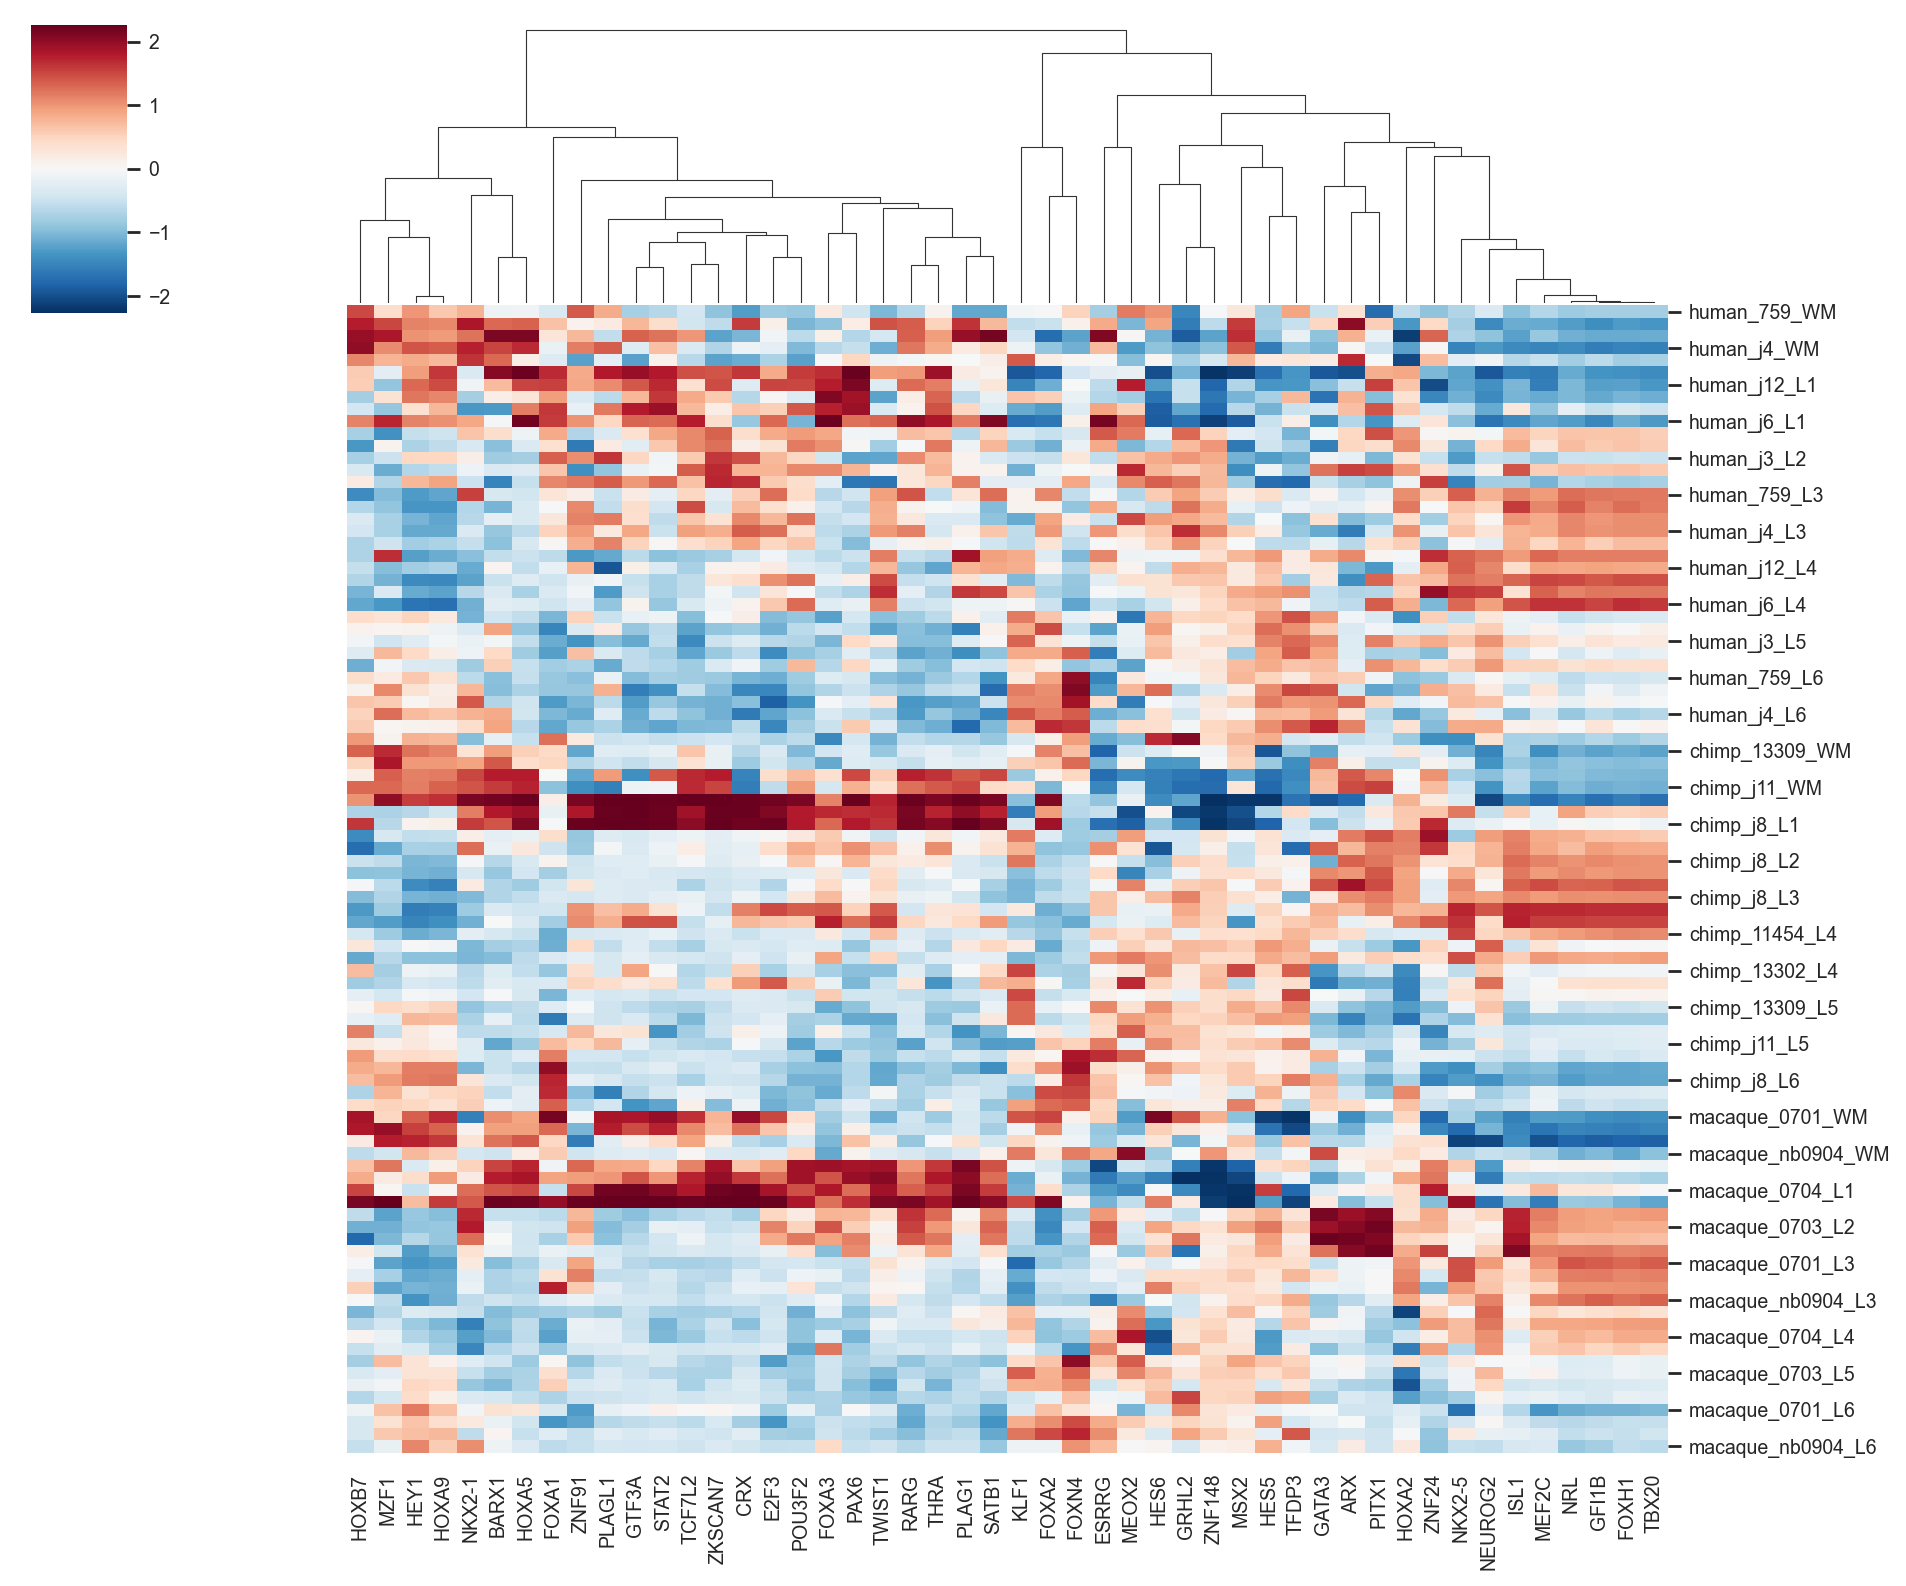

In [25]:
sns.set(font_scale=0.8)
cluster_grid = sns.clustermap(act_df_hs, figsize=(12, 10), cmap="RdBu_r", center=0, metric='cosine', annot_kws={"size": 2}, row_cluster=False)

<Axes: >

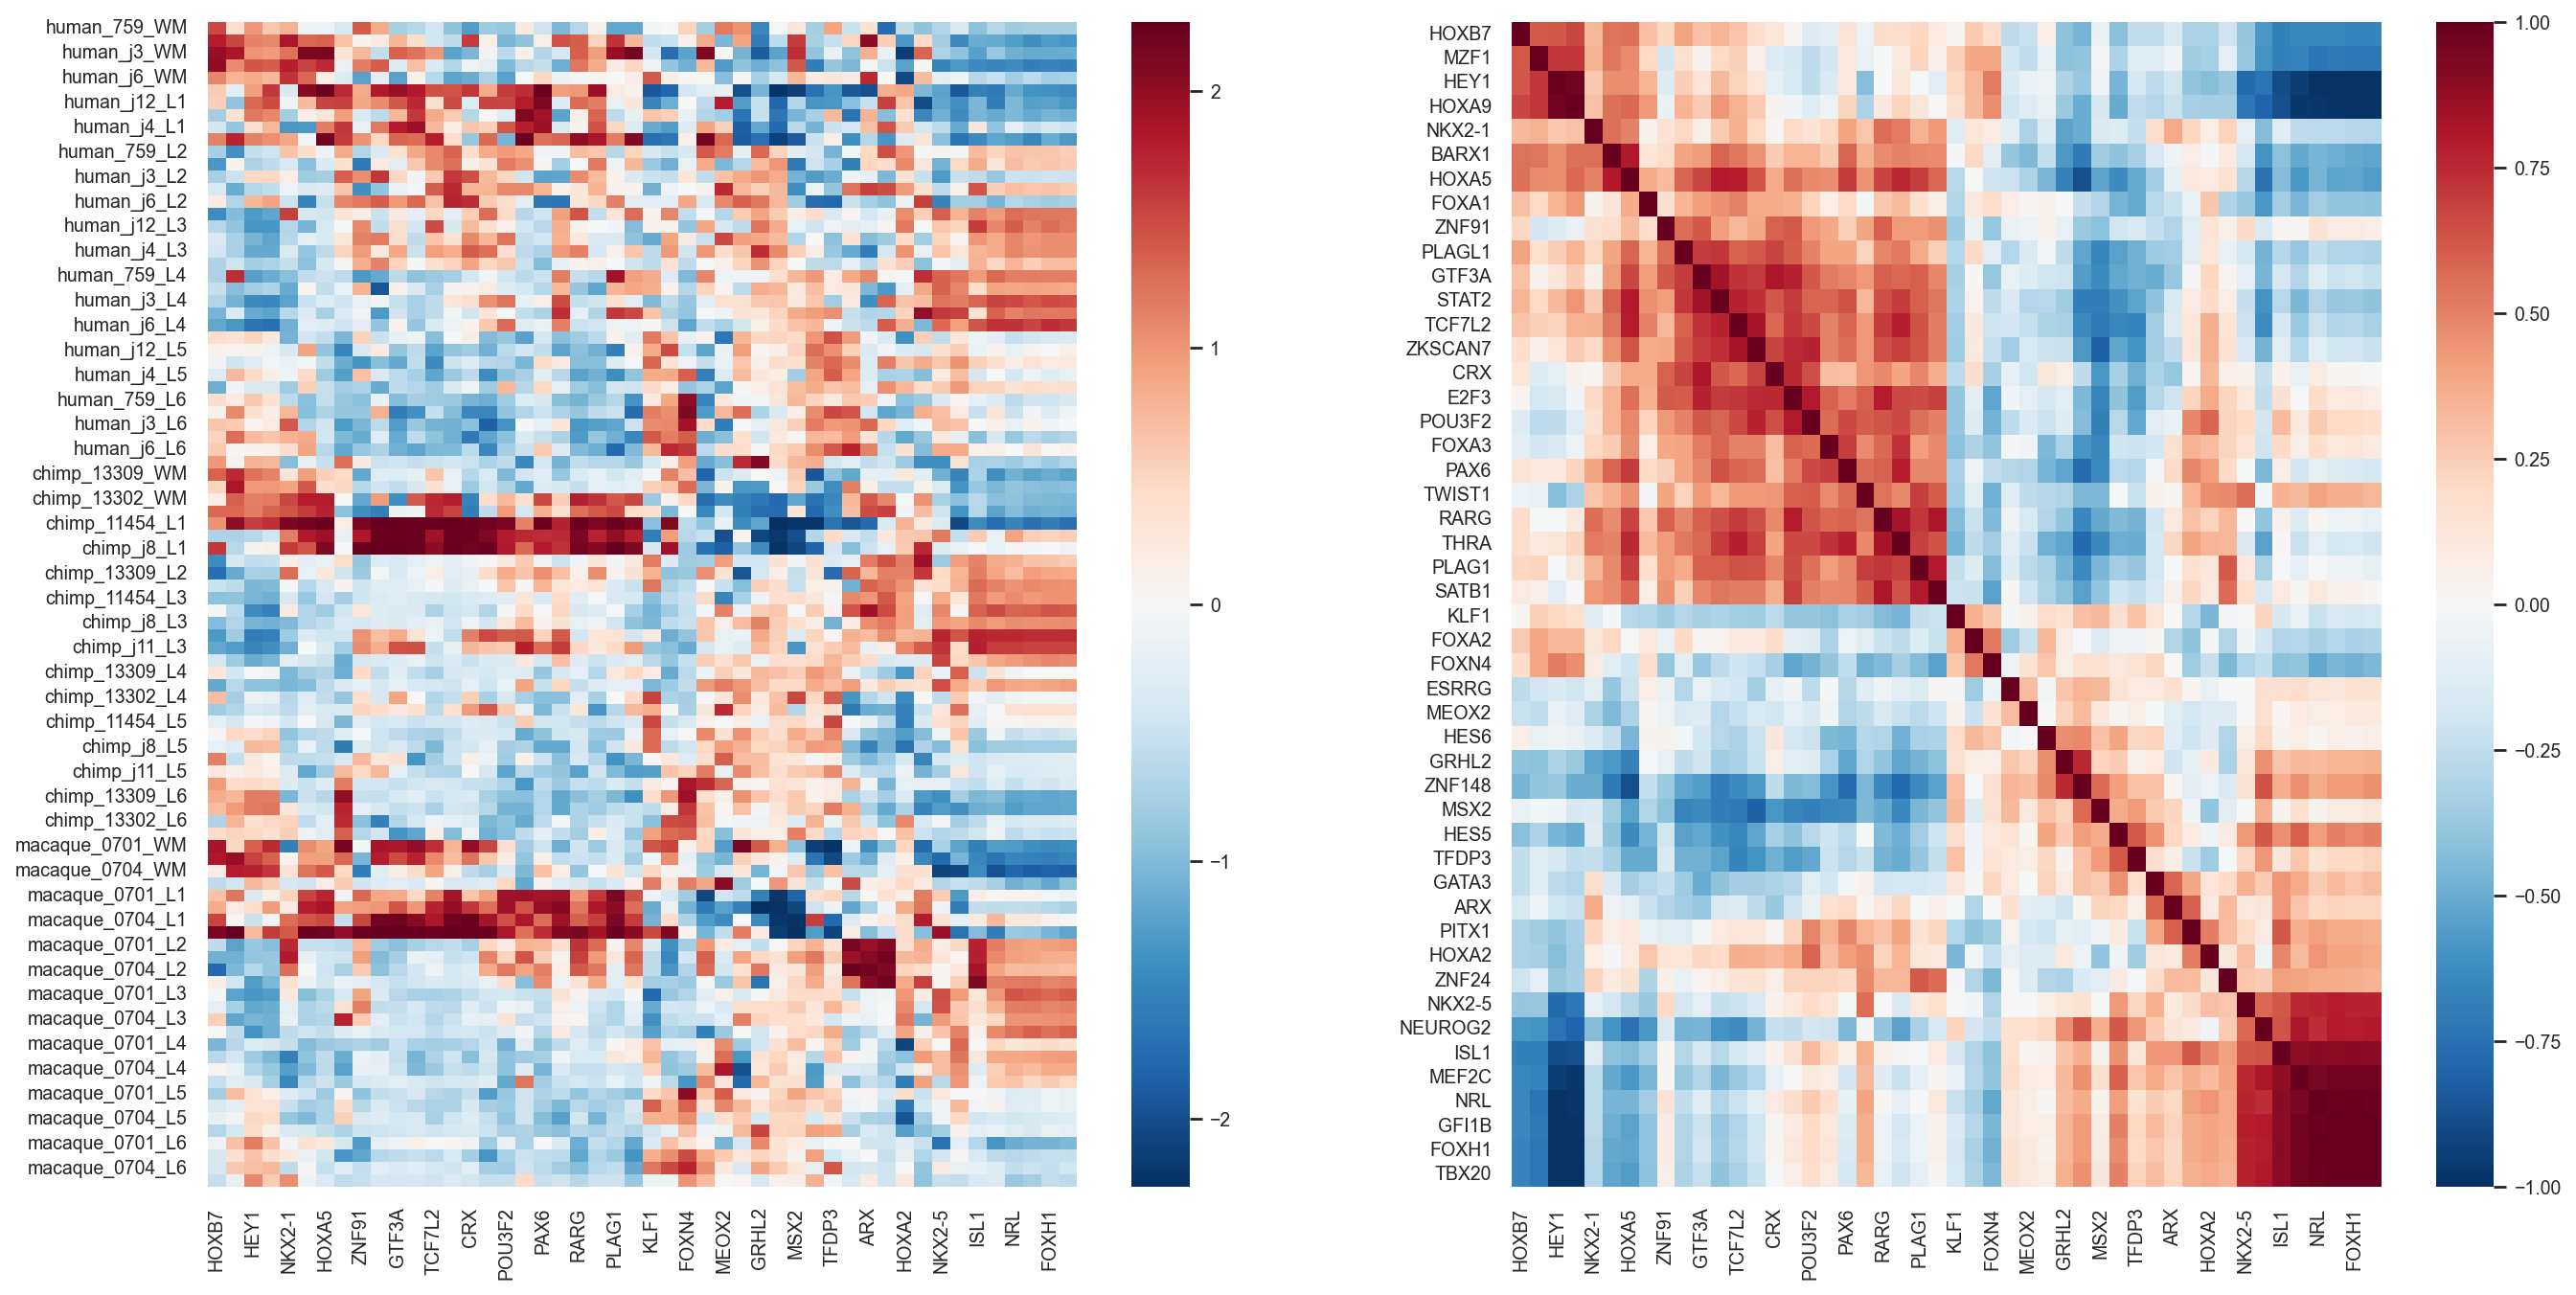

In [26]:
from sklearn.metrics.pairwise import pairwise_kernels
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

gene_order = act_df_hs.columns[cluster_grid.dendrogram_col.reordered_ind]
sns.heatmap(act_df_hs[gene_order], cmap="RdBu_r", center=0, cbar=True, ax=ax[0])

aff_matrix = pairwise_kernels(act_df_hs.T, metric='cosine')
aff_df = pd.DataFrame(aff_matrix, index=act_df_hs.columns, columns=act_df_hs.columns)
sns.heatmap(aff_df.loc[gene_order, gene_order], cmap="RdBu_r", center=0, cbar=True, ax=ax[1], vmin=-1, vmax=1)

In [30]:
collectri[(collectri.source.isin(hs_tf.to_list())) & (collectri.target.isin(hs_genes))]

source    target  weight               PMID
2476    NKX2-5      CALR       1           11106640
12878   NKX2-5       ID2       1           17559079
13433    GATA3      CALR       1           17910949
15216    MEF2C      CALR       1  15998798;18765291
24478    HOXA2      PCP4      -1           23671666
24771    HOXA5      LHX2       1           23864708
30937    HOXA9       ID2       1           20565746
32939    TFDP3  MAP1LC3B       1           22482402
34251   TCF7L2    IGFBP6      -1           14737101
36033    SATB1    IGFBP2       1           17343824
38337     PAX6      LHX2       1           19146846
41187  NEUROG2    ZBTB18       1           23395638

In [31]:
act_df_layer = act_df.copy()
act_df_layer['layer'] = acts.obs.loc[act_df.index, 'layer']
act_df_layer['condition'] = acts.obs.loc[act_df.index, 'condition']
act_df_layer.head()

ABL1     AEBP1       AHR      AIRE       AP1     APEX1  \
human_759_WM -0.749606  0.230137 -0.889791  0.970246  0.319226  0.552654   
human_j12_WM  1.536170  2.000469 -0.162203  1.796740  1.644010  0.093659   
human_j3_WM  -0.534454  1.704133  0.236545  1.811229  1.741848  0.847979   
human_j4_WM  -1.245422  1.624155  0.093211  1.832428  1.249996  1.011348   
human_j6_WM  -0.256517  0.228995 -0.782932  0.171968  0.535617  0.510939   

                    AR    ARID1A    ARID1B    ARID3A  ...    ZNF384    ZNF395  \
human_759_WM  0.437370 -0.154164  0.683915  0.083761  ...  0.590895 -1.338258   
human_j12_WM  1.354494 -0.047791 -0.484264  0.894966  ...  2.132667  1.504393   
human_j3_WM  -0.391152  1.191887 -0.095132 -0.827364  ...  1.834796 -0.162700   
human_j4_WM  -0.972936 -0.580825 -0.018855 -0.042578  ...  1.965692  0.435513   
human_j6_WM   0.632999  0.983600  1.037525 -0.731267  ...  0.387605 -1.868216   

                ZNF423    ZNF436    ZNF699     ZNF76   ZNF804A     ZNF91  \
human_759_WM -0.905555  0.321508 -0.076301 -0.584946  0.943144  1.381857   
human_j12_WM  0.535651 -0.991961 -1.040867 -0.766189 -0.851240  0.095794   
human_j3_WM   0.155240 -1.431275 -1.359343 -2.054123  1.040125  0.739174   
human_j4_WM  -0.001741 -0.346639 -1.806538 -2.024143  0.216786  1.156464   
human_j6_WM  -0.899803  1.198570 -0.325130 -1.344908 -0.326775 -1.236033   

              layer  condition  
human_759_WM     WM      human  
human_j12_WM     WM      human  
human_j3_WM      WM      human  
human_j4_WM      WM      human  
human_j6_WM      WM      human  

[5 rows x 725 columns]

In [32]:
layer_mean = act_df_layer.groupby(['condition', 'layer']).mean()
layer_mean.head()

ABL1     AEBP1       AHR      AIRE       AP1     APEX1  \
condition layer                                                               
chimp     L1     0.248219  1.809251  1.168873 -0.238126  2.056308  1.007452   
          L2    -0.110624  0.062393 -0.426090  1.417481 -0.069926 -0.317888   
          L3    -0.234394 -0.214789  0.950933  0.519248 -0.515123 -1.403912   
          L4     0.544183 -0.310593  0.037154 -0.157166 -0.760511 -0.633819   
          L5     0.358453 -0.337201 -0.549535 -0.665194 -0.566168  0.438164   

                       AR    ARID1A    ARID1B    ARID3A  ...    ZNF362  \
condition layer                                          ...             
chimp     L1     1.393722 -0.915689 -0.948257 -1.017197  ...  1.101023   
          L2    -0.683696  1.257393 -0.361151  0.707644  ...  0.210585   
          L3    -0.188612  0.936396 -0.257223  0.398316  ... -0.529280   
          L4    -0.408663 -0.164052  0.064430  0.602986  ... -0.498320   
          L5    -0.759947 -0.683865  0.225771  0.381231  ... -0.499683   

                   ZNF382    ZNF384    ZNF395    ZNF423    ZNF436    ZNF699  \
condition layer                                                               
chimp     L1    -1.654410  1.725042  0.445404 -0.823315  0.920083 -1.244546   
          L2    -0.942357 -0.572618  0.258549  1.086076  0.177842  1.324056   
          L3    -0.250134 -0.673130  0.738893  1.057371 -0.166666  0.775778   
          L4     0.047077 -0.671885  0.301712  0.347076 -0.042296 -0.015797   
          L5     0.529070 -0.492004 -0.299711  0.113328 -0.463169  0.042872   

                    ZNF76   ZNF804A     ZNF91  
condition layer                                
chimp     L1    -0.929516  0.810657  2.074229  
          L2    -0.692986 -1.519404 -0.725420  
          L3    -0.513047  0.054551  0.307727  
          L4     0.166143  0.195083  0.149669  
          L5     0.006130 -0.157253  0.121483  

[5 rows x 723 columns]

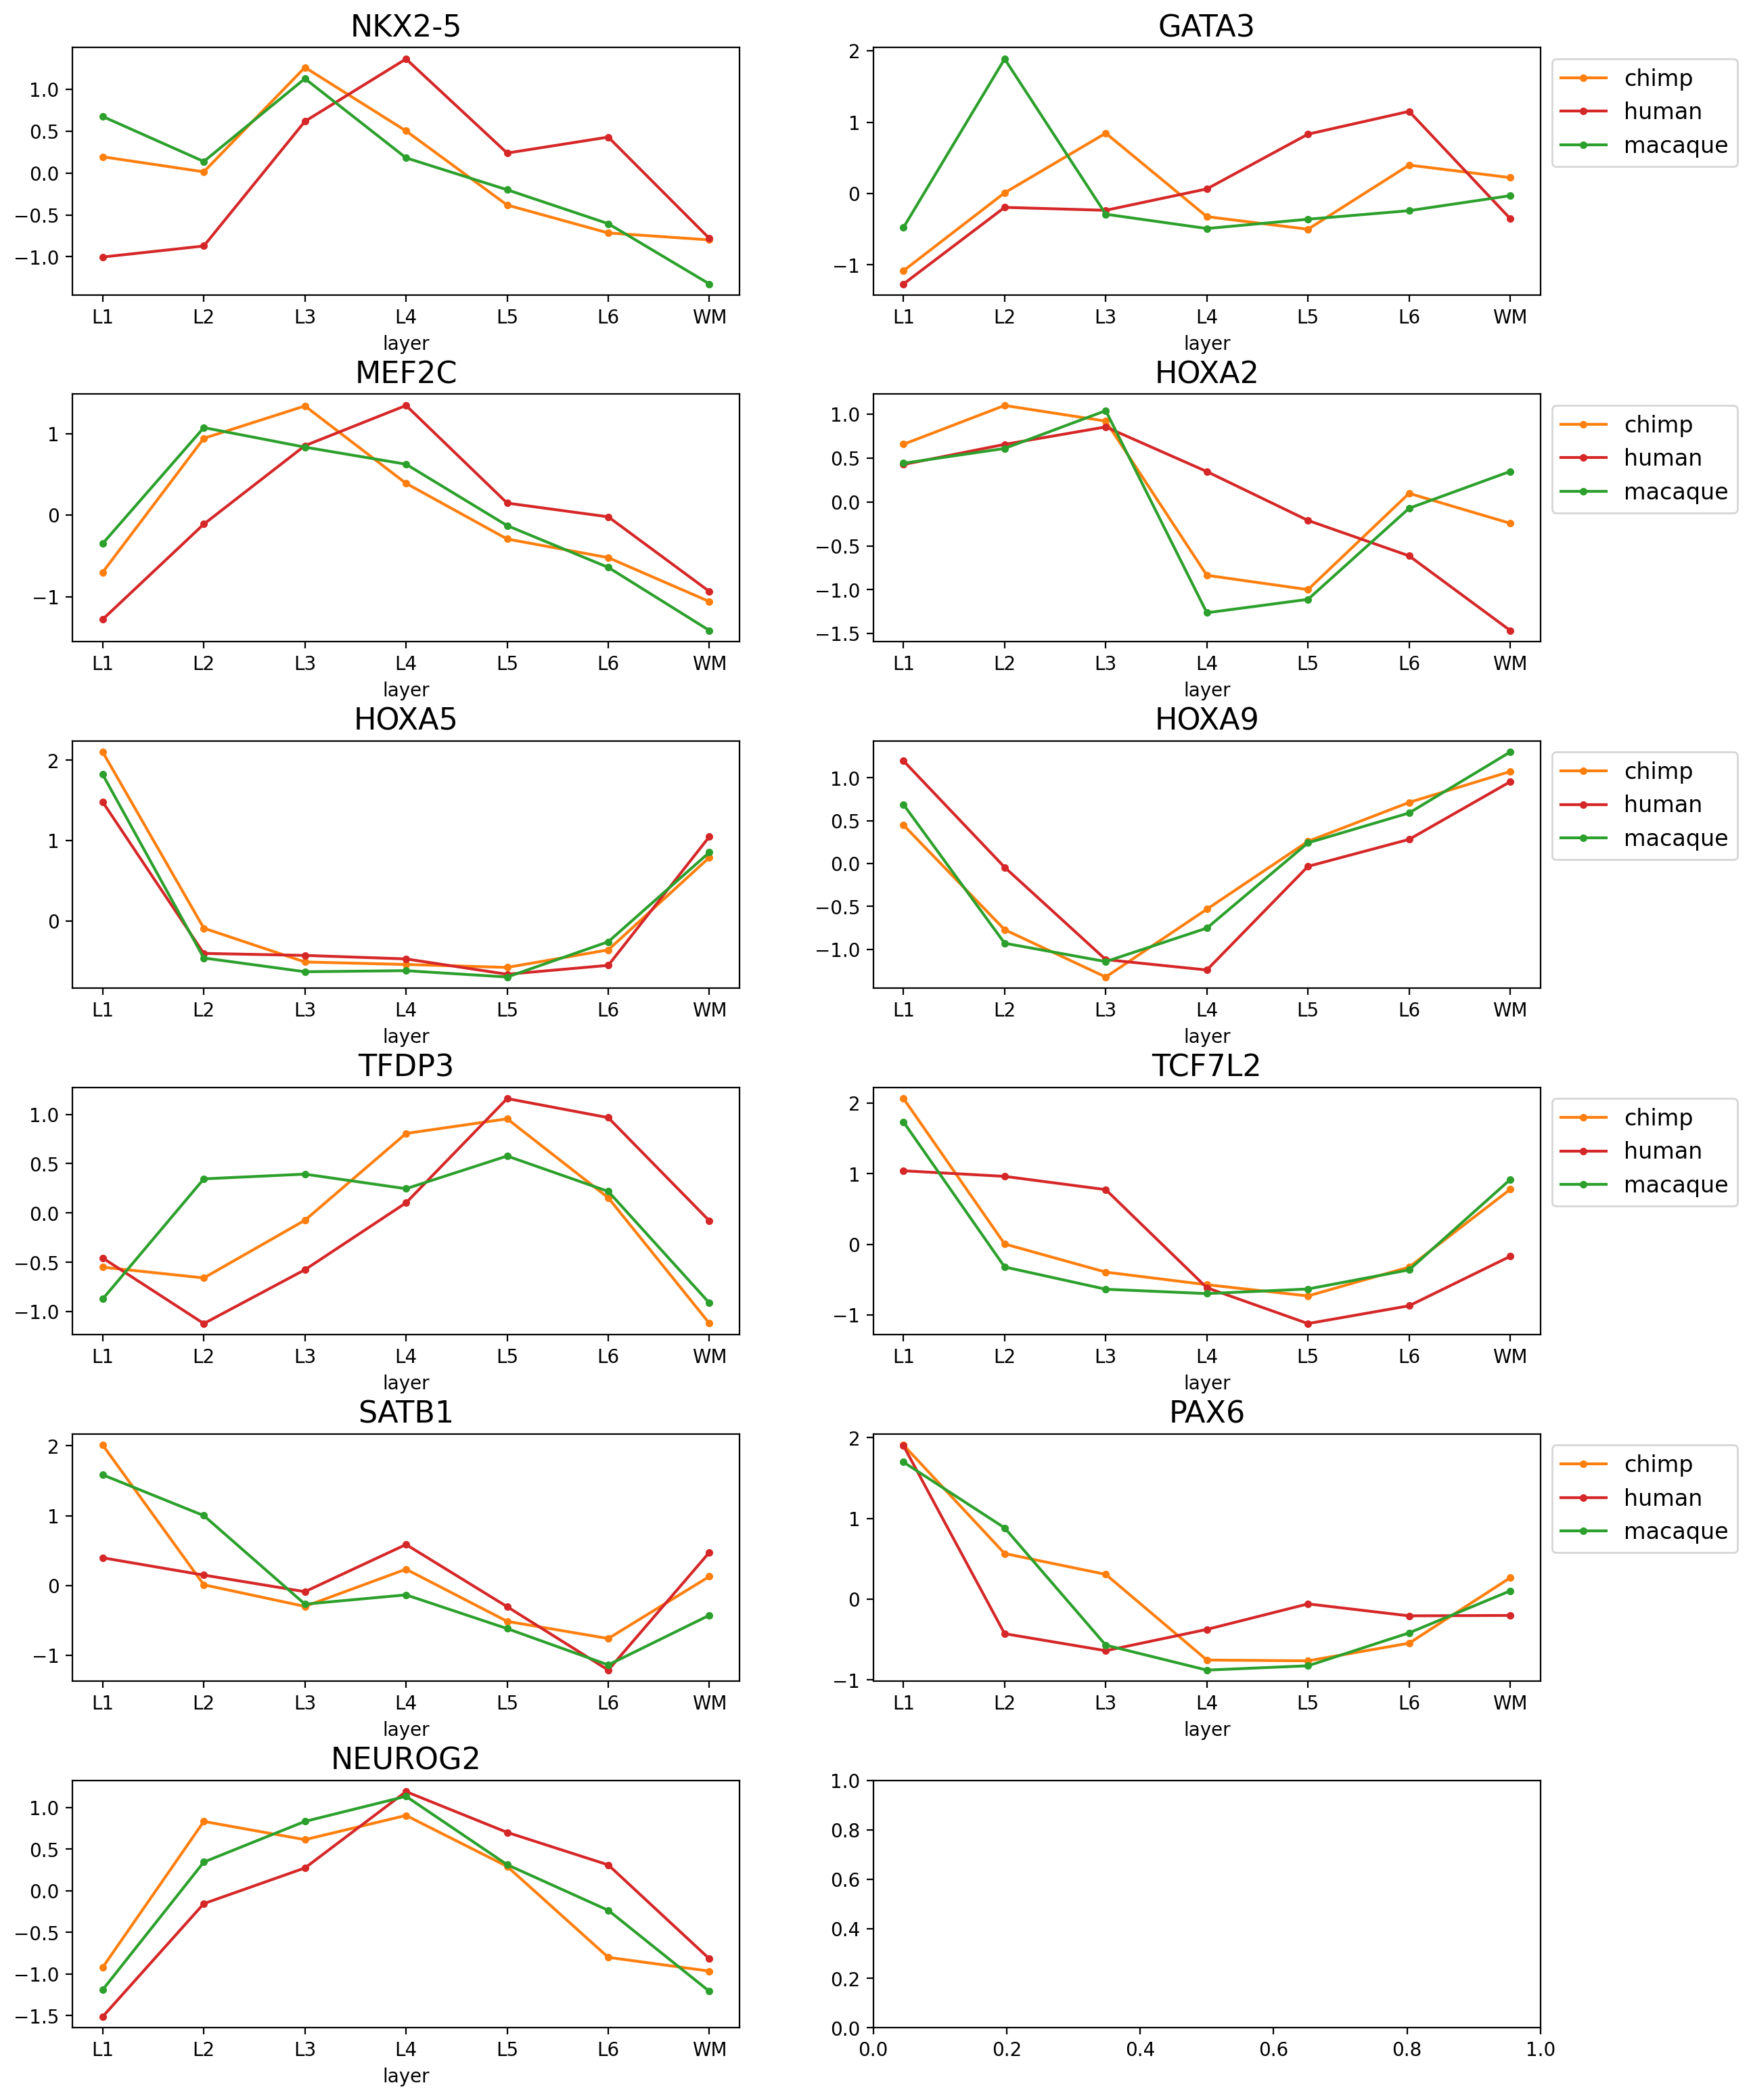

In [33]:
mpl.rcdefaults()
genes = collectri[(collectri.source.isin(hs_tf.to_list())) & (collectri.target.isin(hs_genes))].source.unique().tolist()
fig, axes = plt.subplots((len(genes) + 1) // 2, 2,  figsize=(14, 3.5 * len(genes) // 2), gridspec_kw={'hspace': 0.4})
for gene, ax in zip(genes, axes.flatten()):
    (
        layer_mean[gene]
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax, marker='.')
    )
    
    ax.legend(fontsize=10, loc="upper left", bbox_to_anchor=(1, 1), prop={"size":12})
    if genes.index(gene) % 2 == 0:
        ax.get_legend().remove()
    ax.set_title(gene.upper(), fontsize=16)
    ax.grid(False)

In [34]:
grid = np.linspace(1, 7, 400)
conditions = ['human', 'chimp', 'macaque']
cond_colors = ['tab:red', 'tab:orange', 'tab:green']

In [35]:
df_cont = act_df_layer.copy()
df_cont['layer'] = df_cont.layer.map(dict(zip(sorted(df_cont.layer.unique()), range(1, 8)))).astype(int)

In [36]:
from scipy.interpolate import UnivariateSpline

array = np.zeros((grid.size, len(genes)))
df_list = []

for specie in conditions:
    for i, gene in enumerate(genes):
        #fit spline
        subs_index = df_cont[df_cont.condition == specie].index
        targ_dataset = df_cont.loc[subs_index].copy().sort_values(by='layer')
        x = targ_dataset['layer'].values
        y = targ_dataset[gene].values
        spl = UnivariateSpline(x, y, k=3)
        array[:, i] = spl(grid)
    df_specie = pd.DataFrame(array, columns=genes)
    df_specie['condition'] = specie
    df_list.append(df_specie.copy())
df_spline = pd.concat(df_list)

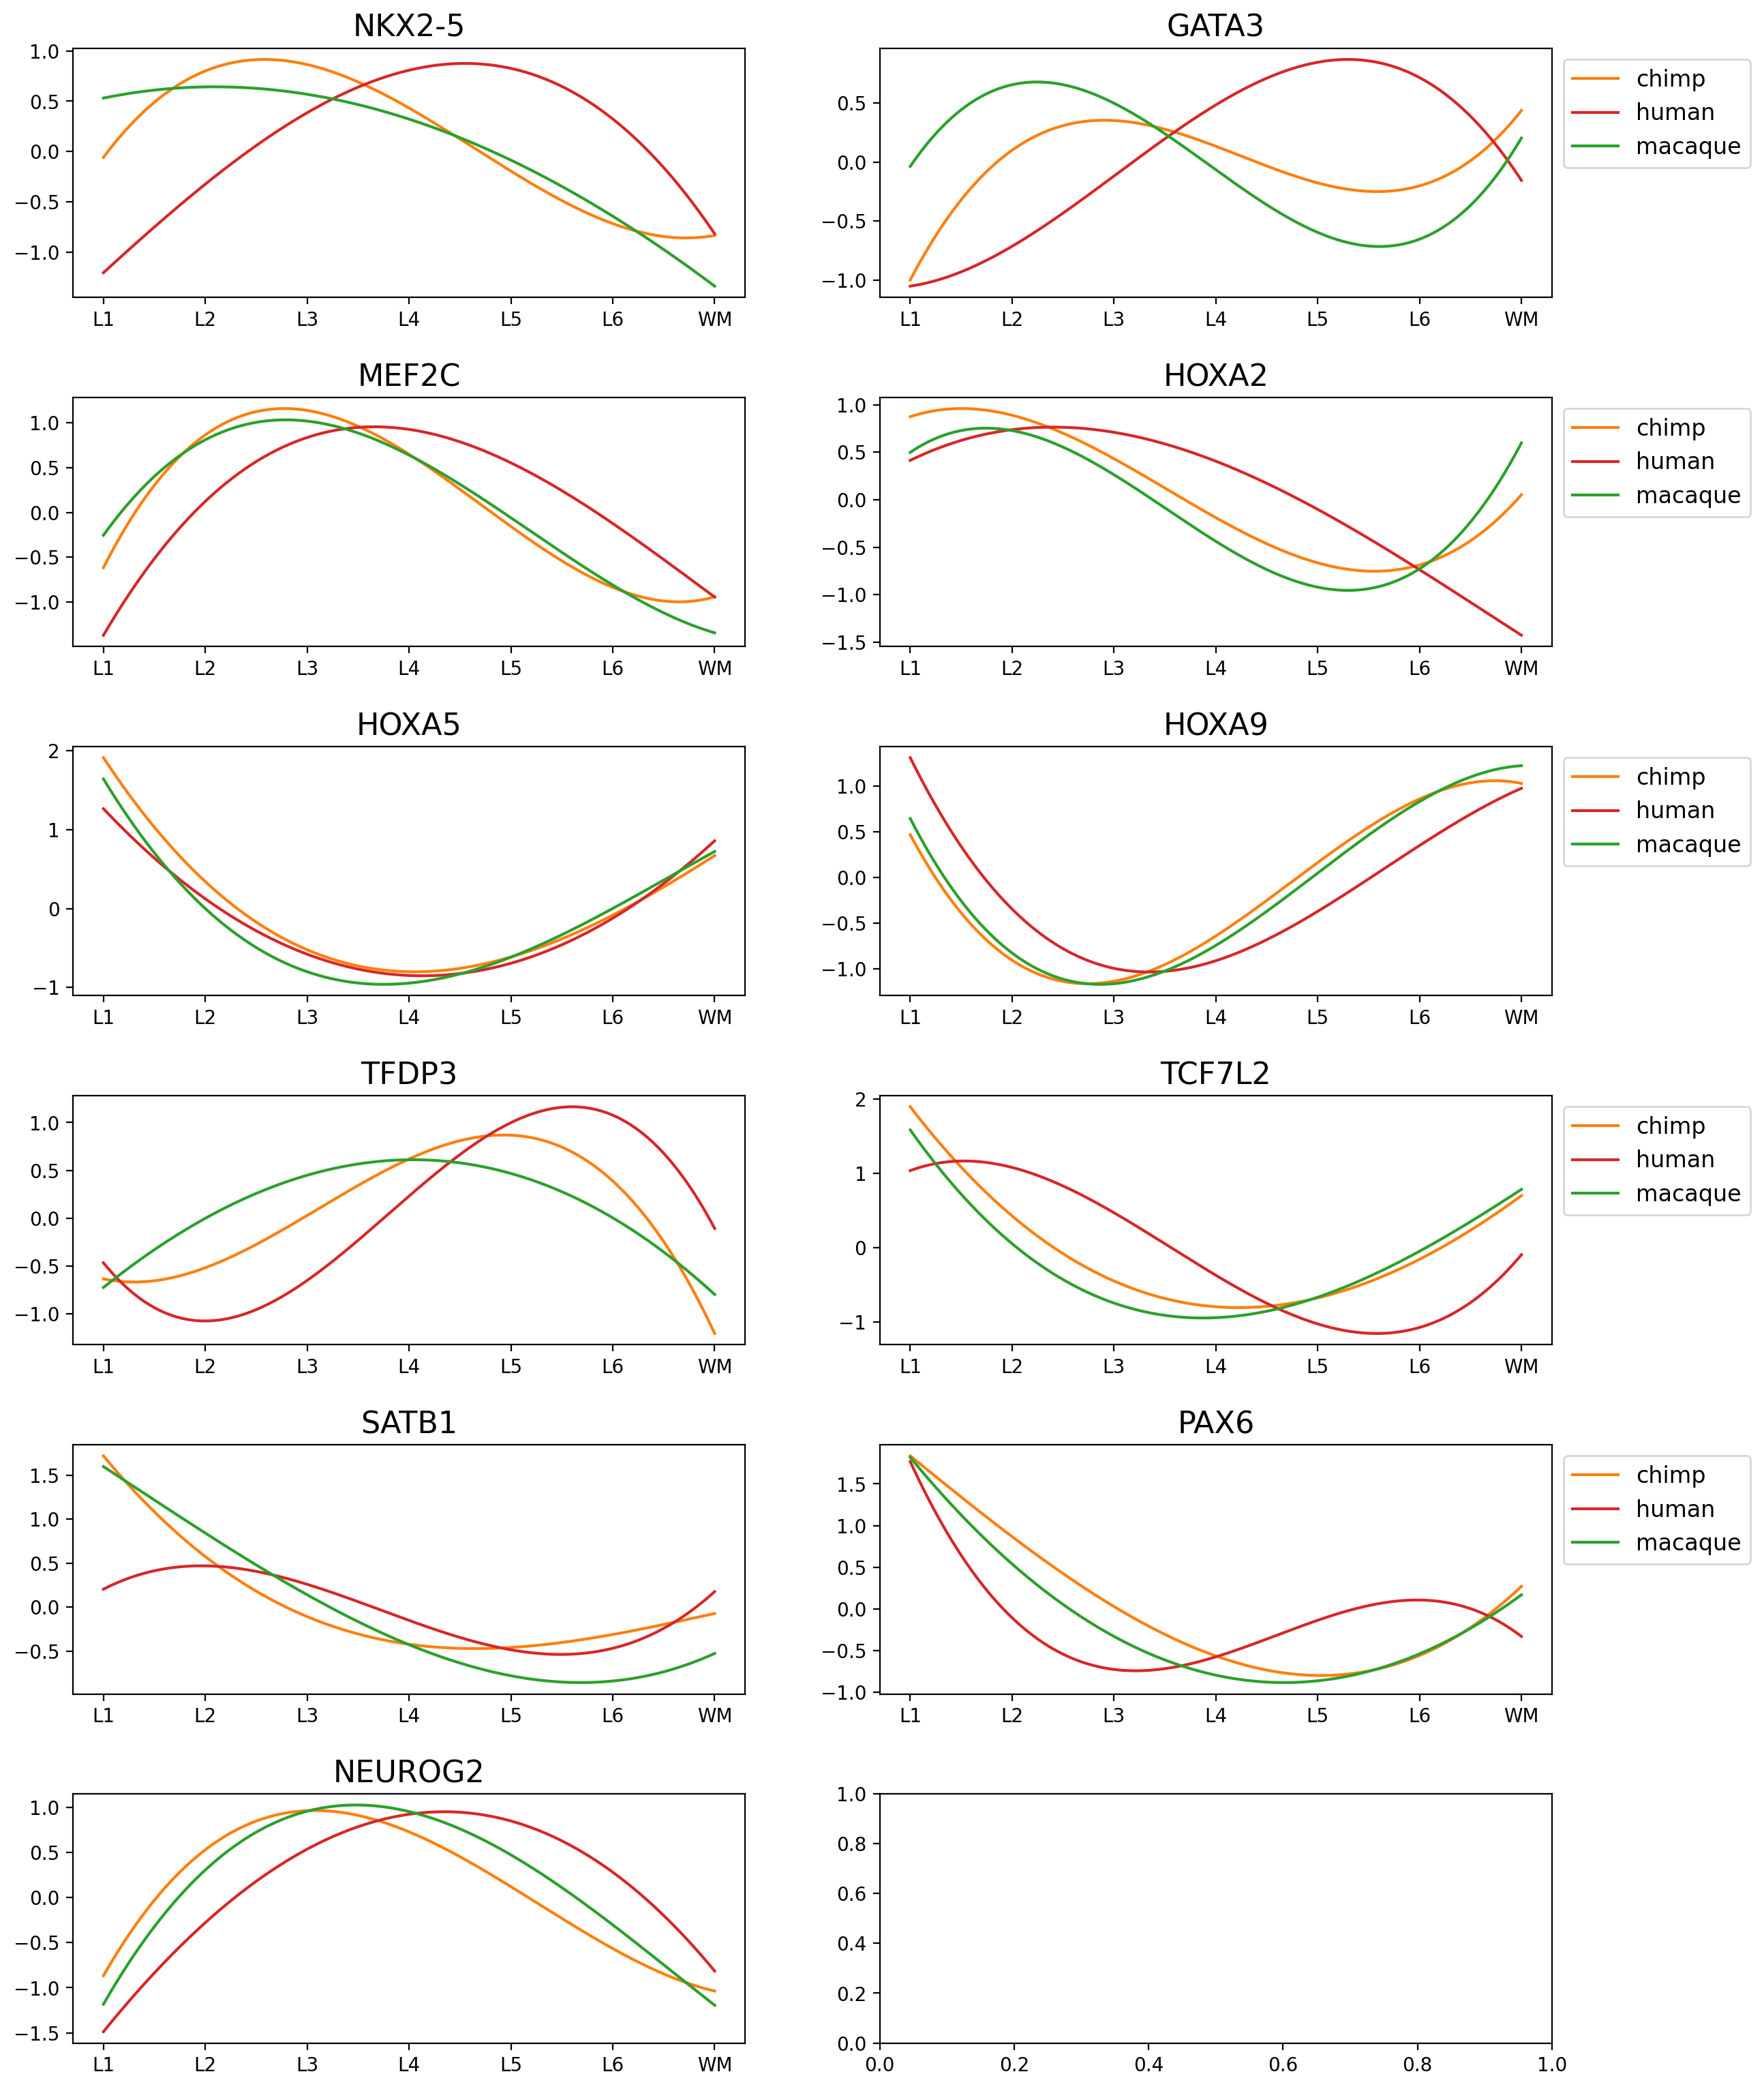

In [37]:
from matplotlib import ticker

mpl.rcdefaults()
fig, axes = plt.subplots((len(genes) + 1) // 2, 2,  figsize=(14, 3.5 * len(genes) // 2), gridspec_kw={'hspace': 0.4})
for gene, ax in zip(genes, axes.flatten()):
    df_cluster_spline = df_spline[[gene, 'condition']]
    df_cluster_spline = df_cluster_spline.pivot(columns='condition', values=gene)
    df_cluster_spline.index = grid
    df_cluster_spline.plot.line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax)

    # plot the dots
    # df_layers = layer_mean[genes].mean(axis=1).reorder_levels(['layer', 'condition']).unstack().loc[layers][conditions]
    # df_layers.index = np.arange(1, 8)
    # ax.set_prop_cycle(color=['tab:red', 'tab:orange', 'tab:green'])
    # ax.plot(df_layers, 'o', alpha=0.7)
    # ax.legend(conditions)
    
    
    ax.legend(fontsize=10, loc="upper left", bbox_to_anchor=(1, 1), prop={"size":12})
    ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(1, 8)))
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
    
    if genes.index(gene) % 2 == 0:
        ax.get_legend().remove()
    ax.set_title(gene.upper(), fontsize=16)
    ax.grid(False)
    #ax.hlines(0, xmin=1, xmax=6, colors='gray', linestyles='dashed')

In [41]:
df = pd.DataFrame(adata_pb_norm.X, index=adata_pb_norm.obs_names, columns=adata_pb_norm.var_names)

In [45]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque']:
    samples = df.loc[df.index.str.contains(cond)].index
    order = sorted(samples.tolist(), key=lambda x: x[-2:])
    order_laminar = list(filter(lambda x: 'L' in x, order))
    order_wm = list(filter(lambda x: 'WM' in x, order))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque']
df = df.loc[sample_order['all']]
df_hs = df[collectri[(collectri.source.isin(hs_tf.to_list())) & (collectri.target.isin(hs_genes))].target.unique()].copy()

In [46]:
df_layer = df.copy()
df_layer['layer'] = adata_pb_norm.obs.loc[df.index, 'layer']
df_layer['condition'] = adata_pb_norm.obs.loc[df.index, 'condition']
df_layer.head()

A1BG      AAAS      AACS     AADAT     AAGAB      AAK1  \
human_759_WM -0.065495  0.010434  0.041268 -0.054351  0.025707 -0.072019   
human_j12_WM -0.060239  0.019742  0.025153 -0.066483 -0.044543  0.001885   
human_j3_WM  -0.095841  0.030377 -0.028083 -0.100378 -0.011412  0.121080   
human_j4_WM  -0.091943  0.057763 -0.020194 -0.100982 -0.054054  0.040012   
human_j6_WM  -0.078252 -0.015277  0.004524 -0.134850  0.010688  0.078731   

                 AAMDC      AAMP      AAR2     AARS1  ...    ZSWIM7    ZSWIM8  \
human_759_WM -0.019207  0.051644 -0.040637  0.007453  ...  0.009901  0.071362   
human_j12_WM  0.120468  0.044115 -0.005605  0.064853  ... -0.000140  0.013841   
human_j3_WM   0.096006 -0.036493 -0.043526 -0.017252  ... -0.022279 -0.063037   
human_j4_WM   0.081541 -0.023853  0.081220  0.055494  ... -0.042334  0.014476   
human_j6_WM  -0.073053  0.049893 -0.014778 -0.074468  ...  0.030391 -0.021561   

                  ZUP1    ZWILCH    ZYG11B       ZYX     ZZEF1      ZZZ3  \
human_759_WM -0.083505  0.041762 -0.026634 -0.087689 -0.063893 -0.040384   
human_j12_WM -0.005179 -0.051615 -0.144635 -0.030077 -0.016105  0.055280   
human_j3_WM   0.055279 -0.082378 -0.050937 -0.060124 -0.077665  0.020677   
human_j4_WM   0.012403 -0.117408 -0.020468 -0.110733 -0.023327  0.078987   
human_j6_WM   0.130150 -0.005066  0.020878 -0.112694 -0.059420  0.027191   

              layer  condition  
human_759_WM     WM      human  
human_j12_WM     WM      human  
human_j3_WM      WM      human  
human_j4_WM      WM      human  
human_j6_WM      WM      human  

[5 rows x 9210 columns]

In [47]:
layer_mean = df_layer.groupby(['condition', 'layer']).mean()
layer_mean.head()

A1BG      AAAS      AACS     AADAT     AAGAB      AAK1  \
condition layer                                                               
chimp     L1     0.000311  0.022240 -0.067096  0.004136  0.006259 -0.005820   
          L2    -0.025557 -0.011629 -0.121551 -0.001924  0.009986 -0.014660   
          L3     0.076603 -0.015677 -0.020433  0.028048  0.006021 -0.007055   
          L4     0.062482  0.018768  0.042894  0.007185  0.013482 -0.018464   
          L5    -0.010620 -0.016573  0.077460 -0.009728 -0.012463 -0.007488   

                    AAMDC      AAMP      AAR2     AARS1  ...    ZSWIM5  \
condition layer                                          ...             
chimp     L1     0.031259  0.010712  0.019617  0.015548  ...  0.015811   
          L2    -0.024830 -0.007021  0.020408 -0.027253  ... -0.002635   
          L3    -0.009535 -0.020843 -0.009666 -0.005945  ... -0.002672   
          L4     0.000866  0.018736  0.018289 -0.009535  ... -0.002672   
          L5    -0.007860  0.018095 -0.016876 -0.010588  ... -0.000386   

                   ZSWIM6    ZSWIM7    ZSWIM8      ZUP1    ZWILCH    ZYG11B  \
condition layer                                                               
chimp     L1     0.004193 -0.044921 -0.016086 -0.101012  0.002993 -0.007331   
          L2    -0.006481  0.093601  0.046118  0.026112  0.003258  0.005846   
          L3    -0.001571 -0.013281  0.005516  0.004399 -0.002625 -0.000610   
          L4    -0.005166 -0.009858 -0.008125  0.003925  0.004127  0.001754   
          L5    -0.001691 -0.043626  0.002484  0.015830 -0.012560 -0.001946   

                      ZYX     ZZEF1      ZZZ3  
condition layer                                
chimp     L1     0.005605 -0.036471  0.012691  
          L2    -0.003745  0.016427  0.025918  
          L3     0.003216 -0.007998 -0.017862  
          L4     0.003341 -0.013224 -0.037157  
          L5    -0.002624 -0.006421 -0.014971  

[5 rows x 9208 columns]

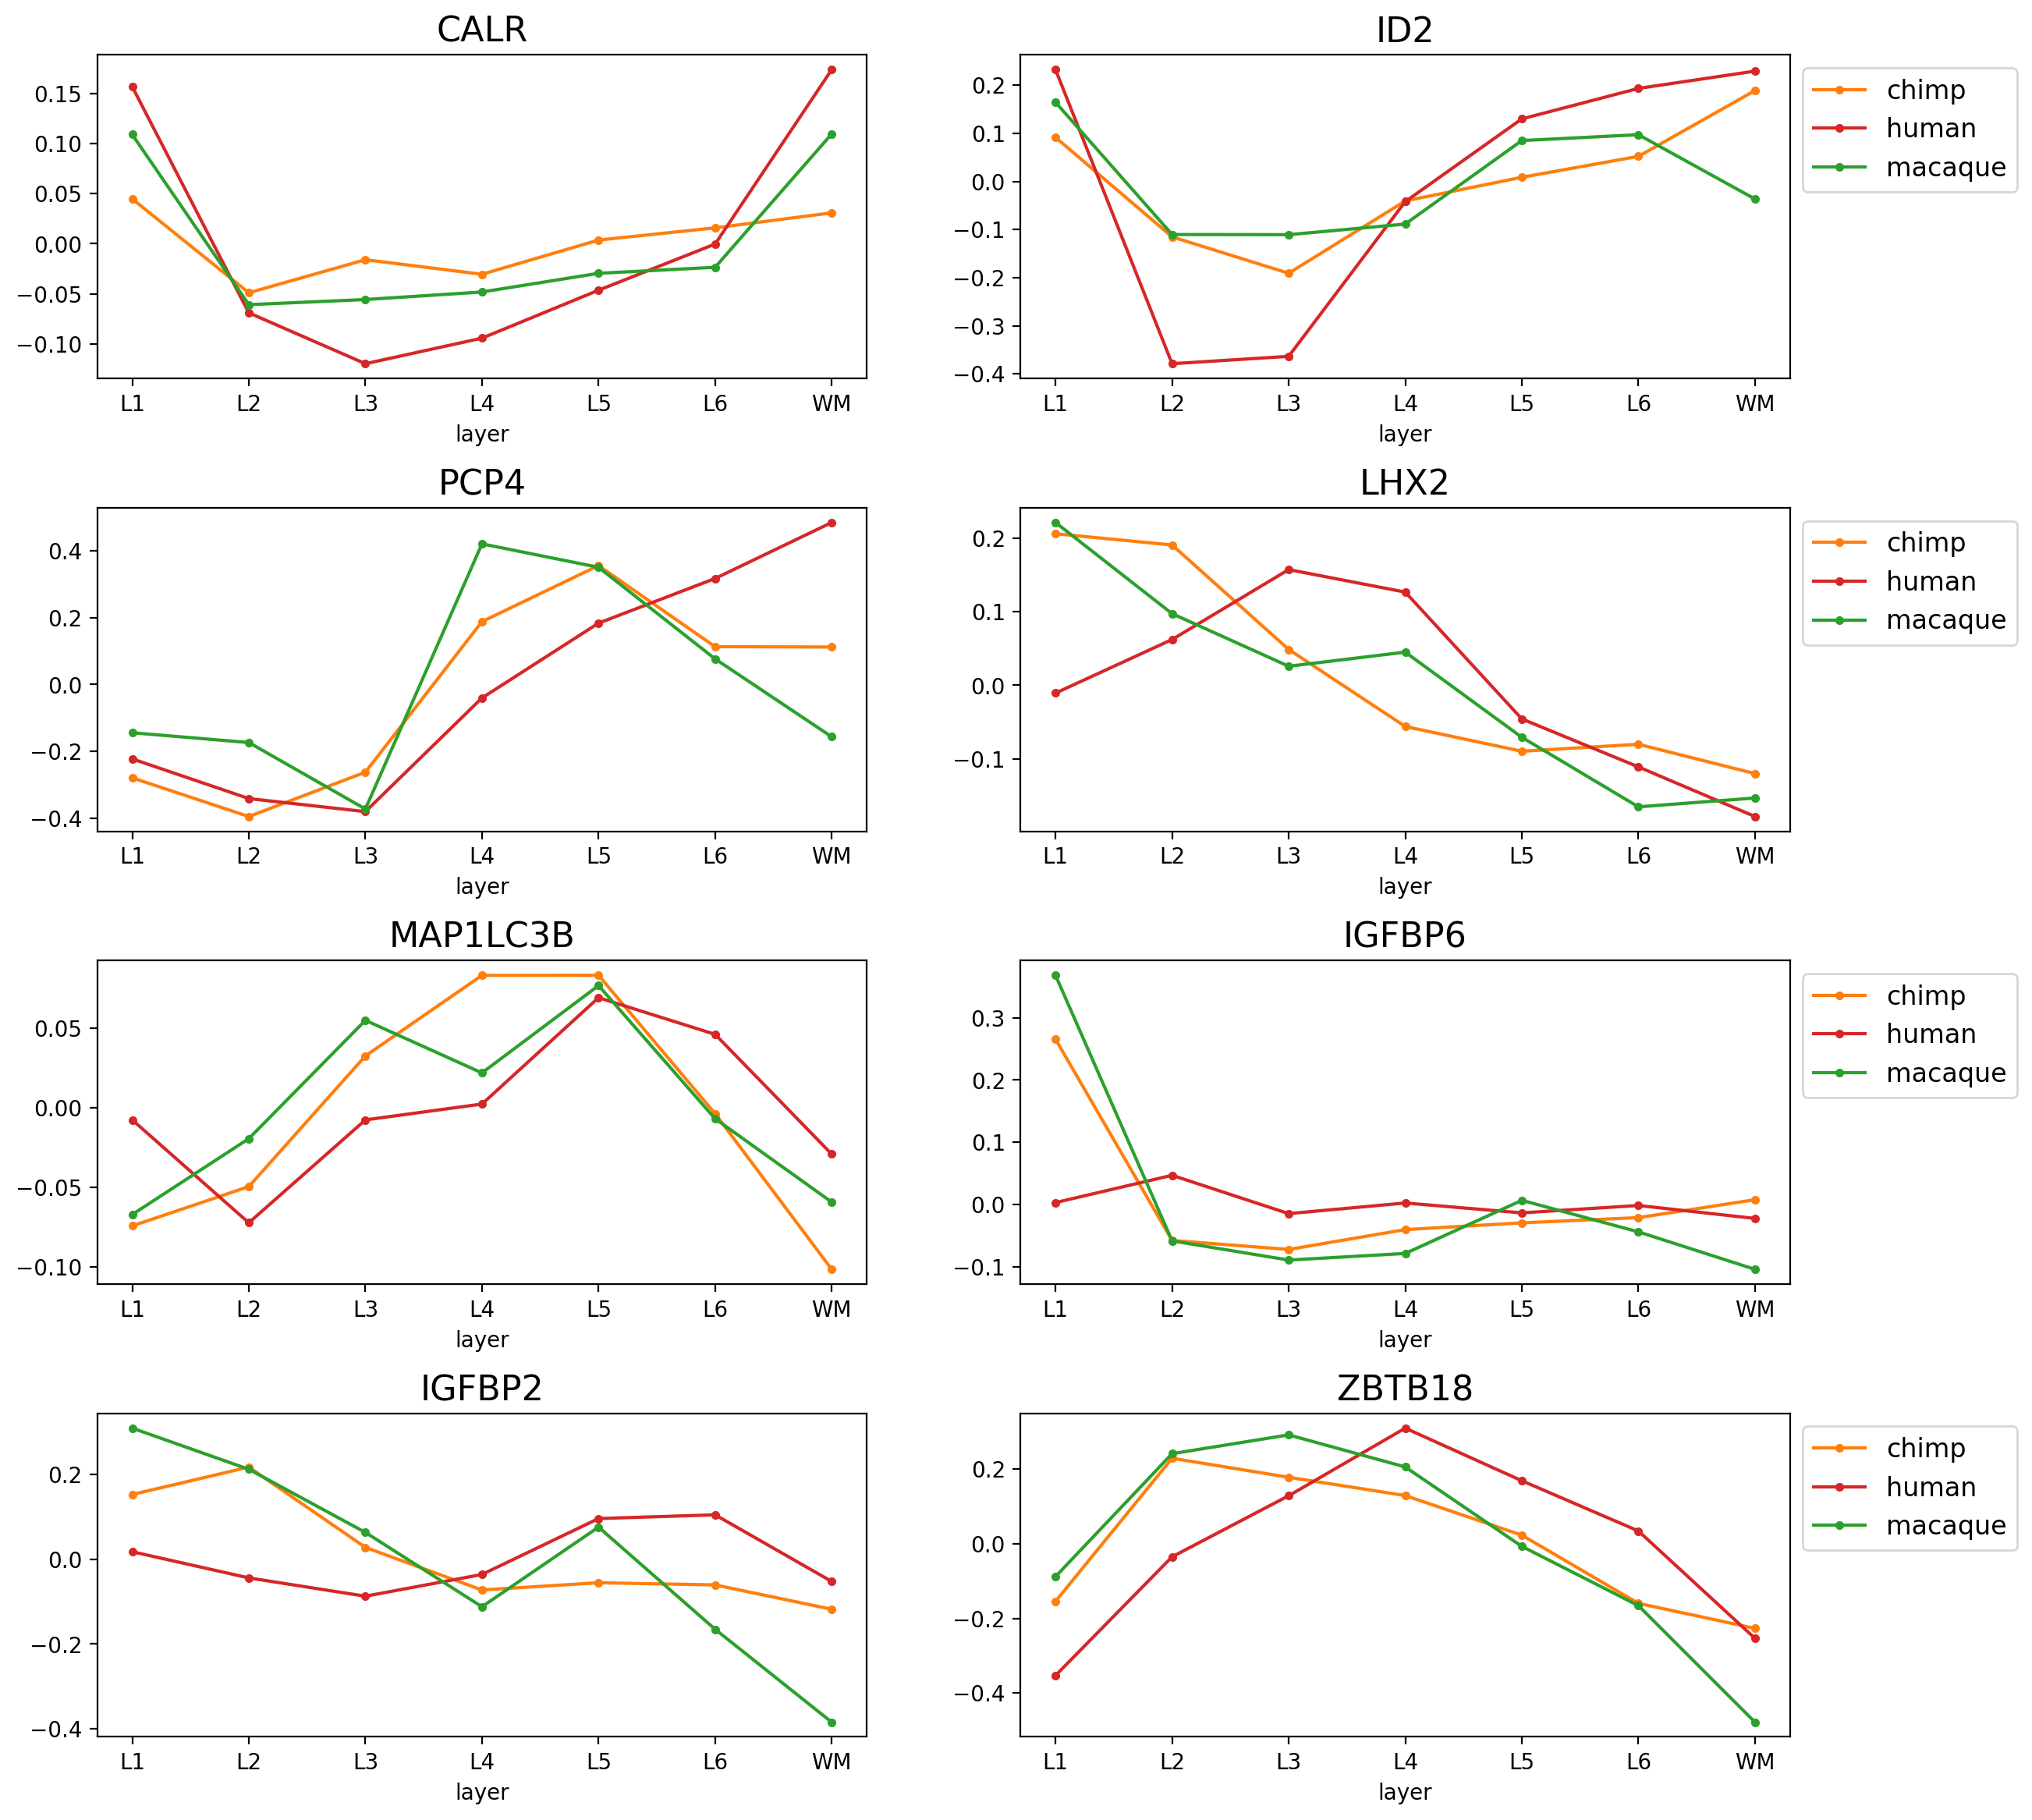

In [48]:
mpl.rcdefaults()
genes = collectri[(collectri.source.isin(hs_tf.to_list())) & (collectri.target.isin(hs_genes))].target.unique().tolist()
fig, axes = plt.subplots((len(genes) + 1) // 2, 2,  figsize=(14, 3.5 * len(genes) // 2), gridspec_kw={'hspace': 0.4})
for gene, ax in zip(genes, axes.flatten()):
    (
        layer_mean[gene]
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax, marker='.')
    )
    
    ax.legend(fontsize=10, loc="upper left", bbox_to_anchor=(1, 1), prop={"size":12})
    if genes.index(gene) % 2 == 0:
        ax.get_legend().remove()
    ax.set_title(gene.upper(), fontsize=16)
    ax.grid(False)

In [49]:
grid = np.linspace(1, 7, 400)
conditions = ['human', 'chimp', 'macaque']
cond_colors = ['tab:red', 'tab:orange', 'tab:green']

In [65]:
df_cont = df_layer.copy()
df_cont['layer'] = df_cont.layer.map(dict(zip(sorted(df_cont.layer.unique()), range(1, 8)))).astype(int)

In [66]:
from scipy.interpolate import UnivariateSpline

array = np.zeros((grid.size, len(genes)))
df_list = []

for specie in conditions:
    for i, gene in enumerate(genes):
        #fit spline
        subs_index = df_cont[df_cont.condition == specie].index
        targ_dataset = df_cont.loc[subs_index].copy().sort_values(by='layer')
        x = targ_dataset['layer'].values
        y = targ_dataset[gene].values
        spl = UnivariateSpline(x, y, k=3)
        array[:, i] = spl(grid)
    df_specie = pd.DataFrame(array, columns=genes)
    df_specie['condition'] = specie
    df_list.append(df_specie.copy())
df_spline = pd.concat(df_list)

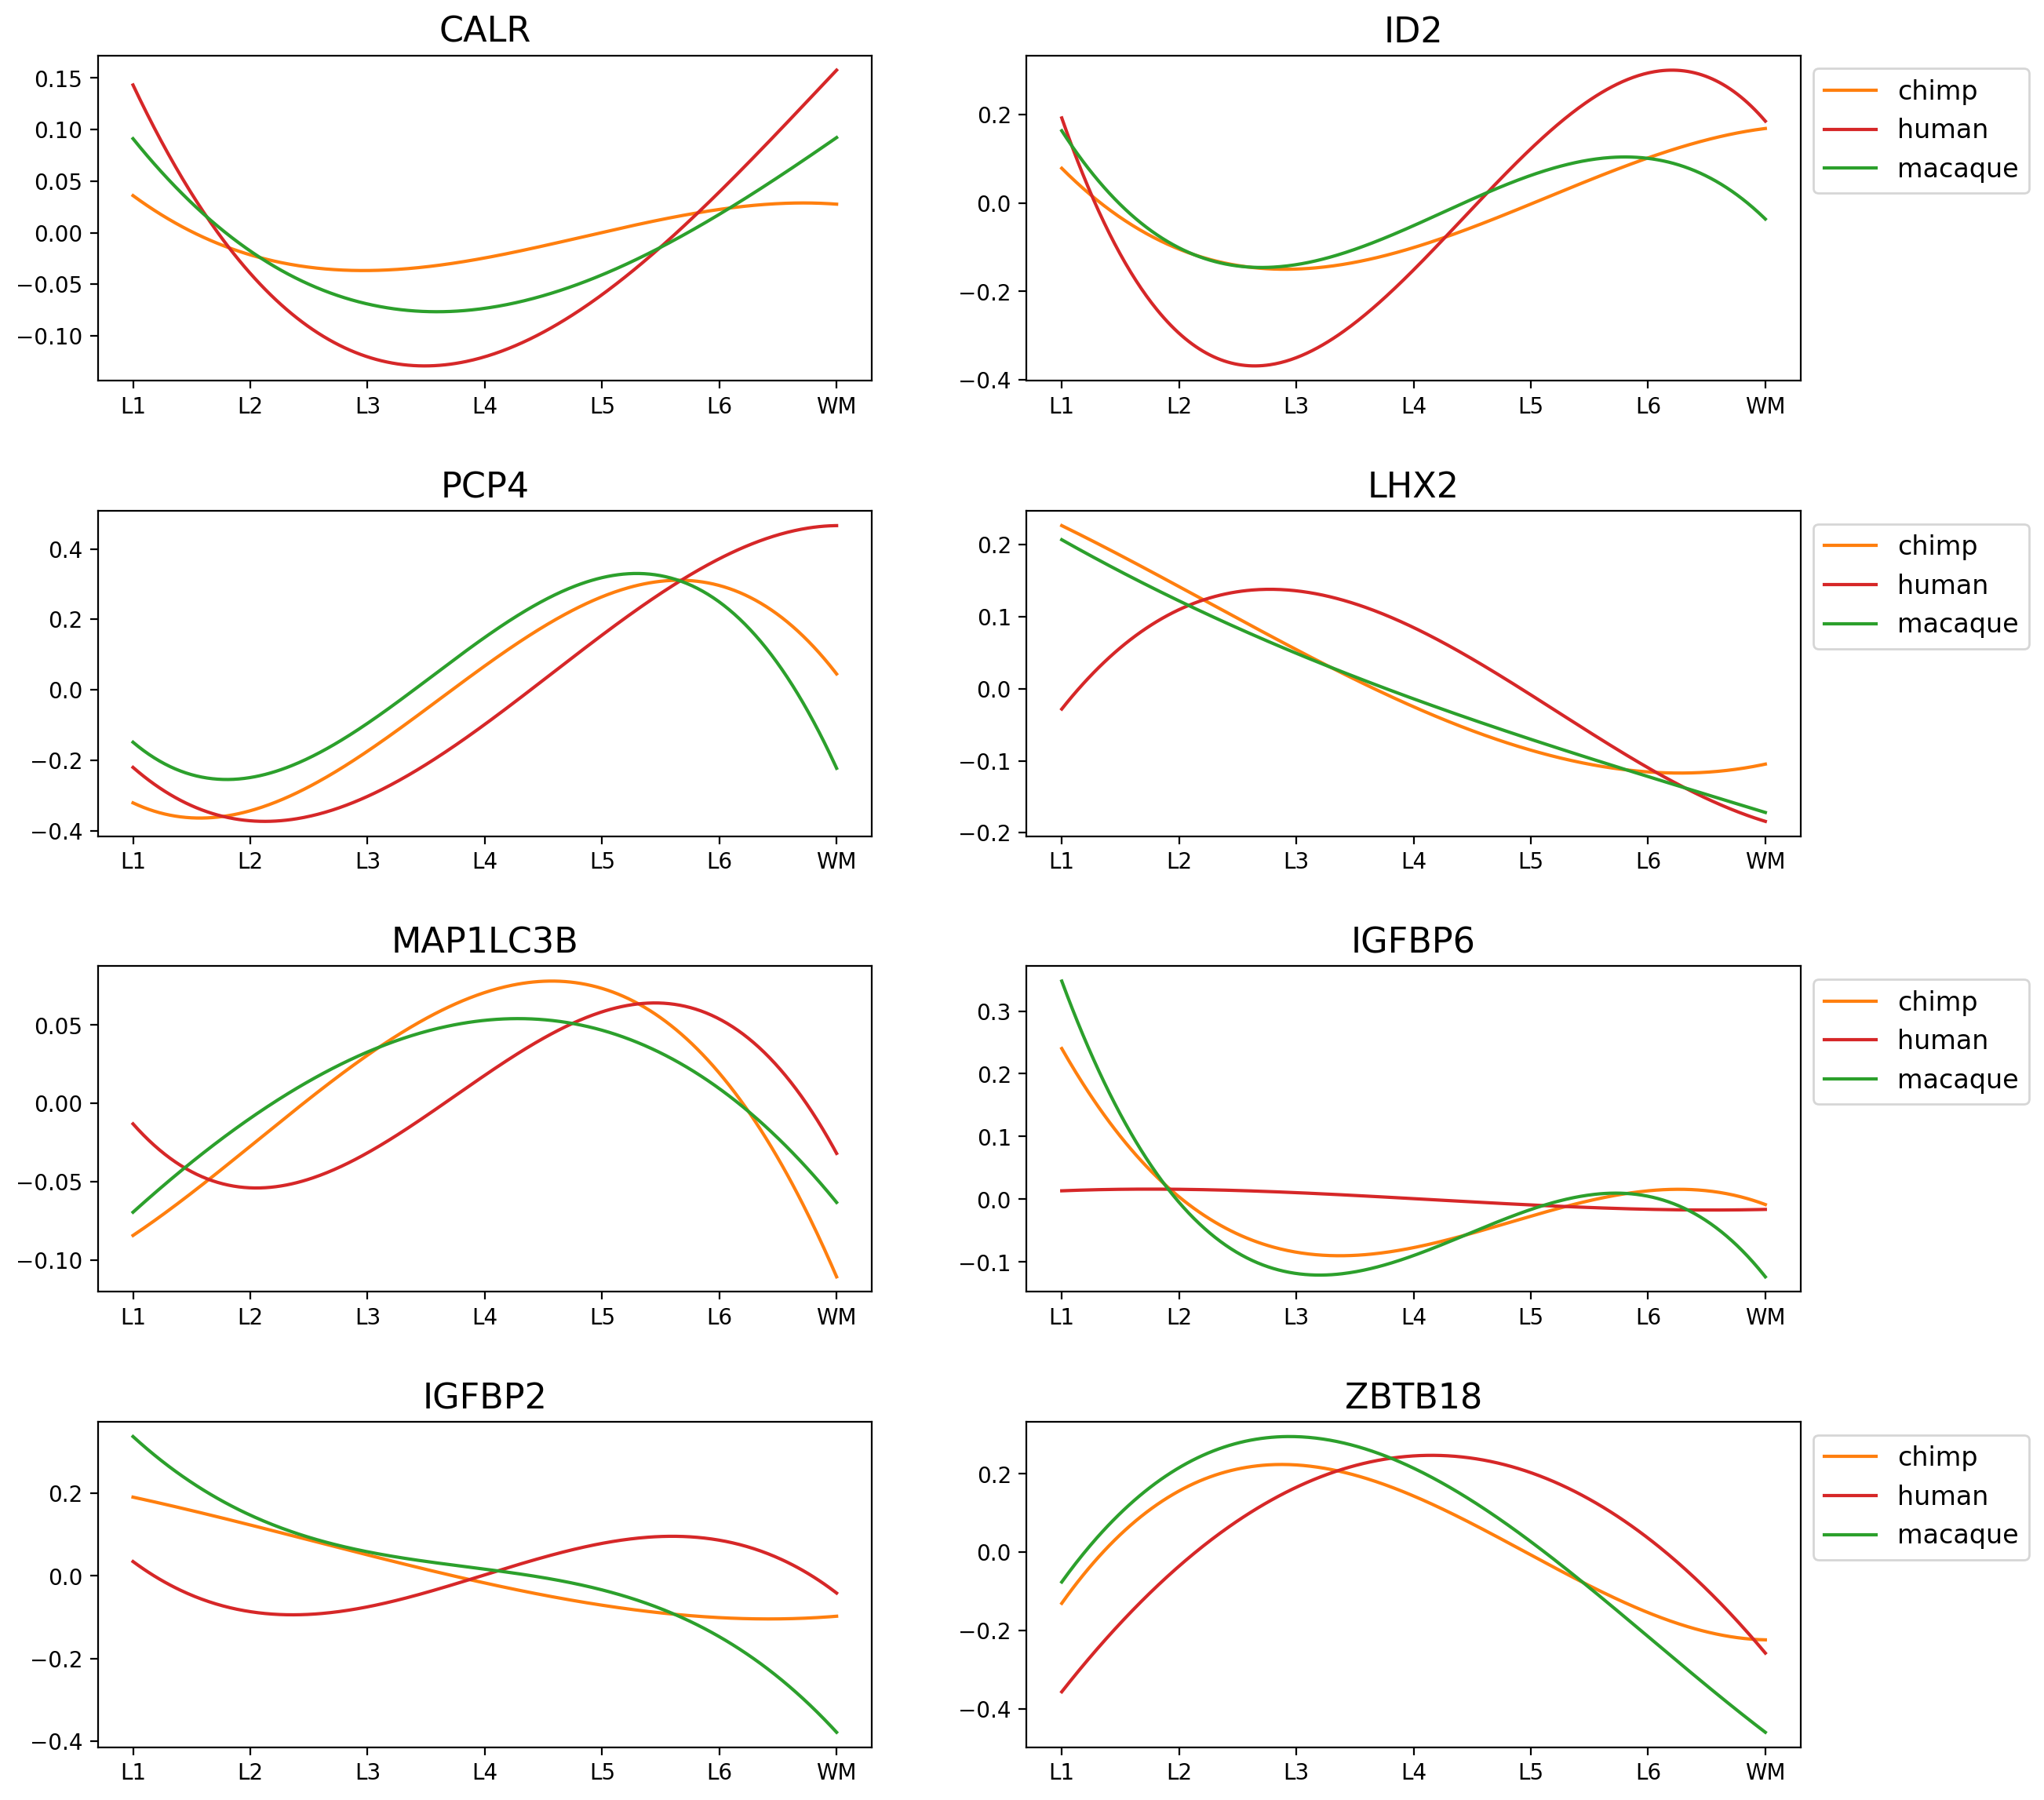

In [68]:
from matplotlib import ticker

mpl.rcdefaults()
fig, axes = plt.subplots((len(genes) + 1) // 2, 2,  figsize=(14, 3.5 * len(genes) // 2), gridspec_kw={'hspace': 0.4})
for gene, ax in zip(genes, axes.flatten()):
    df_cluster_spline = df_spline[[gene, 'condition']]
    df_cluster_spline = df_cluster_spline.pivot(columns='condition', values=gene)
    df_cluster_spline.index = grid
    df_cluster_spline.plot.line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax)

    # plot the dots
    # df_layers = layer_mean[genes].mean(axis=1).reorder_levels(['layer', 'condition']).unstack().loc[layers][conditions]
    # df_layers.index = np.arange(1, 8)
    # ax.set_prop_cycle(color=['tab:red', 'tab:orange', 'tab:green'])
    # ax.plot(df_layers, 'o', alpha=0.7)
    # ax.legend(conditions)
    
    
    ax.legend(fontsize=10, loc="upper left", bbox_to_anchor=(1, 1), prop={"size":12})
    ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(1, 8)))
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
    
    if genes.index(gene) % 2 == 0:
        ax.get_legend().remove()
    ax.set_title(gene.upper(), fontsize=16)
    ax.grid(False)
    #ax.hlines(0, xmin=1, xmax=6, colors='gray', linestyles='dashed')

In [117]:
gene_df = df[df_spline.columns[:-1]].copy()
act_df = act_df[collectri[(collectri.source.isin(hs_tf.to_list())) & (collectri.target.isin(hs_genes))].source.unique().tolist()].copy()

corr_df = pd.concat([gene_df, act_df], axis=1)
corr_df = corr_df.corr(method='spearman').loc[act_df.columns, gene_df.columns]
corr_df

CALR       ID2      PCP4      LHX2  MAP1LC3B    IGFBP6    IGFBP2  \
NKX2-5  -0.424855 -0.165152 -0.231359  0.400970  0.382244 -0.074549  0.324991   
GATA3   -0.191879 -0.034321  0.035308 -0.098604  0.116633 -0.133027  0.104545   
MEF2C   -0.681410 -0.534457 -0.289343  0.506112  0.312887 -0.255567  0.292850   
HOXA2   -0.299762 -0.388015 -0.955993  0.584150 -0.188015 -0.008512  0.343531   
HOXA5    0.484525  0.271416 -0.227835  0.159551 -0.598910  0.221008  0.009346   
HOXA9    0.718863  0.617382  0.339666 -0.504682 -0.325349  0.263739 -0.222302   
TFDP3   -0.147089  0.186959  0.491777 -0.278805  0.840586 -0.203541  0.112496   
TCF7L2   0.255465 -0.103830 -0.534287  0.270276 -0.583197  0.302775 -0.038032   
SATB1    0.075826  0.080729 -0.193735  0.404648 -0.250340  0.186772  0.276830   
PAX6     0.306844  0.248144 -0.392680  0.311525 -0.354733  0.184900  0.427051   
NEUROG2 -0.668046 -0.353456  0.050732  0.277886  0.502622 -0.345608  0.148298   

           ZBTB18  
NKX2-5   0.678022  
GATA3    0.249132  
MEF2C    0.910078  
HOXA2    0.341879  
HOXA5   -0.483844  
HOXA9   -0.890501  
TFDP3    0.271263  
TCF7L2  -0.415611  
SATB1    0.090909  
PAX6    -0.114709  
NEUROG2  0.879265

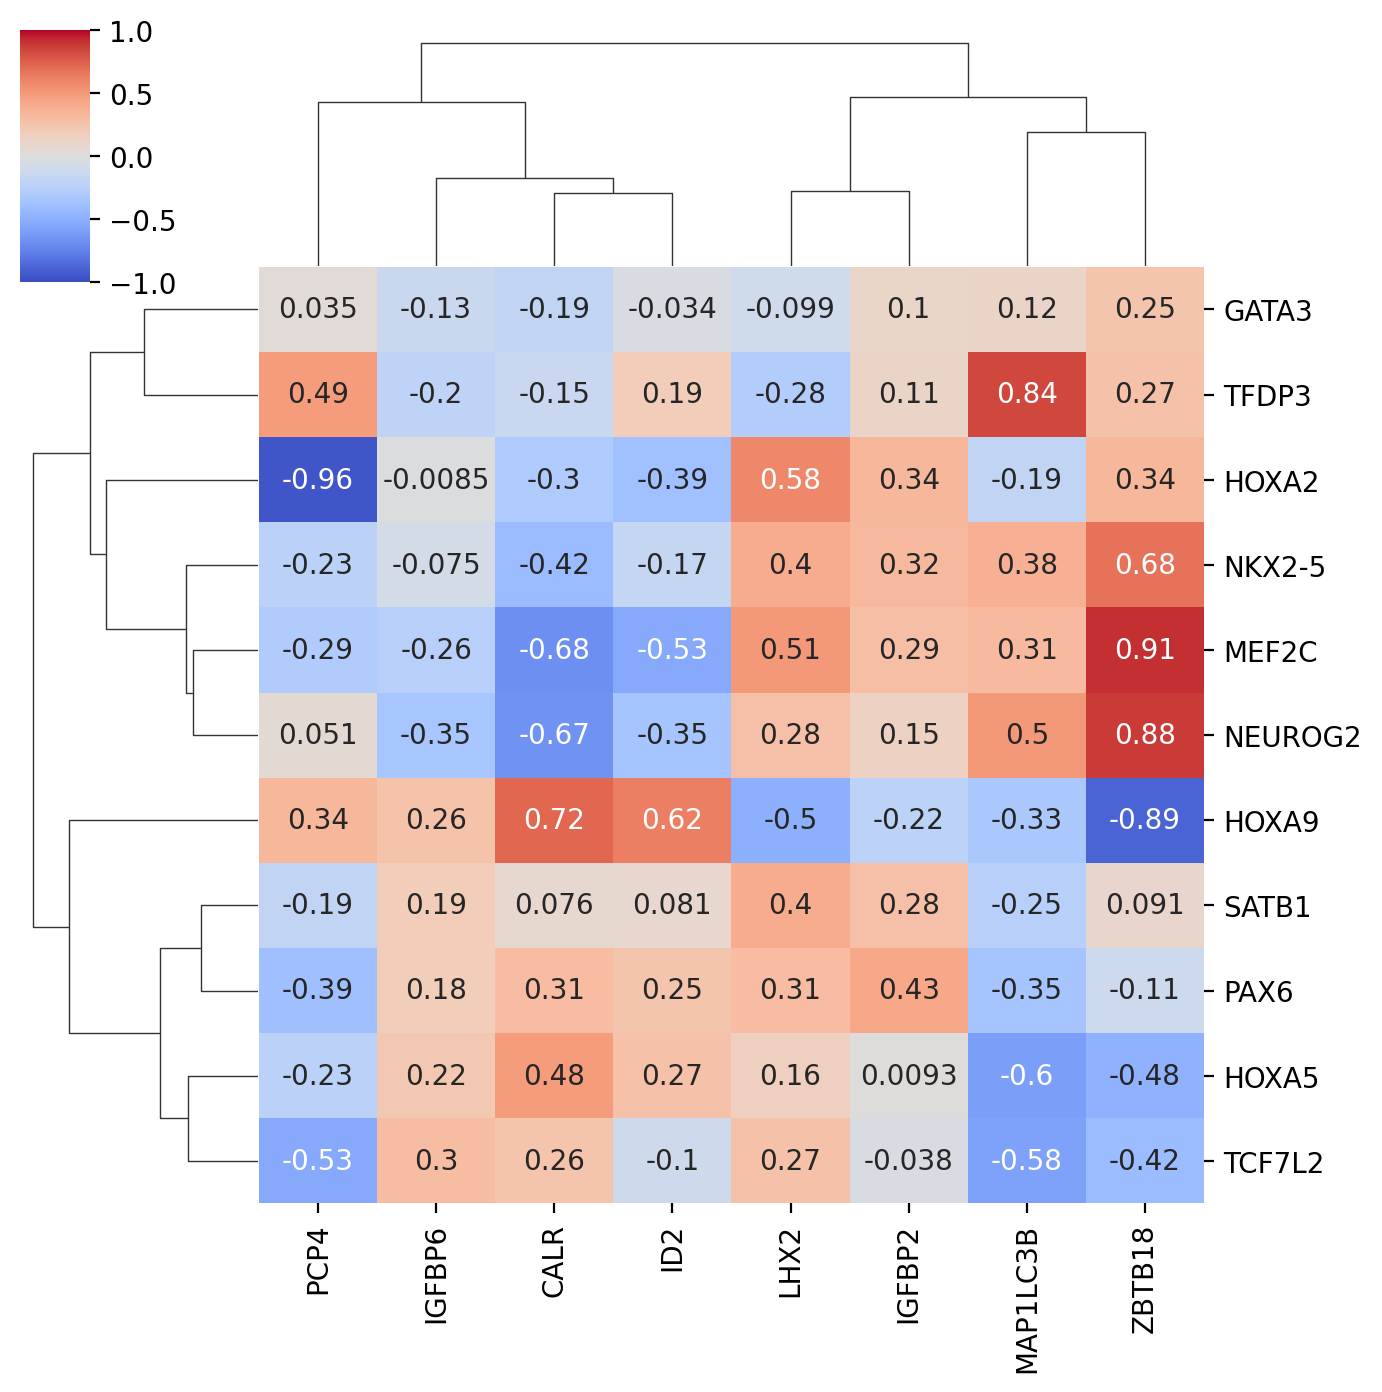

In [118]:
sns.clustermap(corr_df, cmap='coolwarm', center=0, vmin=-1, vmax=1, figsize=(7, 7), annot=True)

In [119]:
corr_mask = corr_df.copy()
corr_mask.loc[:] = 1

for source, target in collectri[(collectri.source.isin(hs_tf.to_list())) & (collectri.target.isin(hs_genes))][['source', 'target']].values.tolist():
    corr_mask.loc[source, target] = 0
corr_mask

CALR  ID2  PCP4  LHX2  MAP1LC3B  IGFBP6  IGFBP2  ZBTB18
NKX2-5    0.0  0.0   1.0   1.0       1.0     1.0     1.0     1.0
GATA3     0.0  1.0   1.0   1.0       1.0     1.0     1.0     1.0
MEF2C     0.0  1.0   1.0   1.0       1.0     1.0     1.0     1.0
HOXA2     1.0  1.0   0.0   1.0       1.0     1.0     1.0     1.0
HOXA5     1.0  1.0   1.0   0.0       1.0     1.0     1.0     1.0
HOXA9     1.0  0.0   1.0   1.0       1.0     1.0     1.0     1.0
TFDP3     1.0  1.0   1.0   1.0       0.0     1.0     1.0     1.0
TCF7L2    1.0  1.0   1.0   1.0       1.0     0.0     1.0     1.0
SATB1     1.0  1.0   1.0   1.0       1.0     1.0     0.0     1.0
PAX6      1.0  1.0   1.0   0.0       1.0     1.0     1.0     1.0
NEUROG2   1.0  1.0   1.0   1.0       1.0     1.0     1.0     0.0

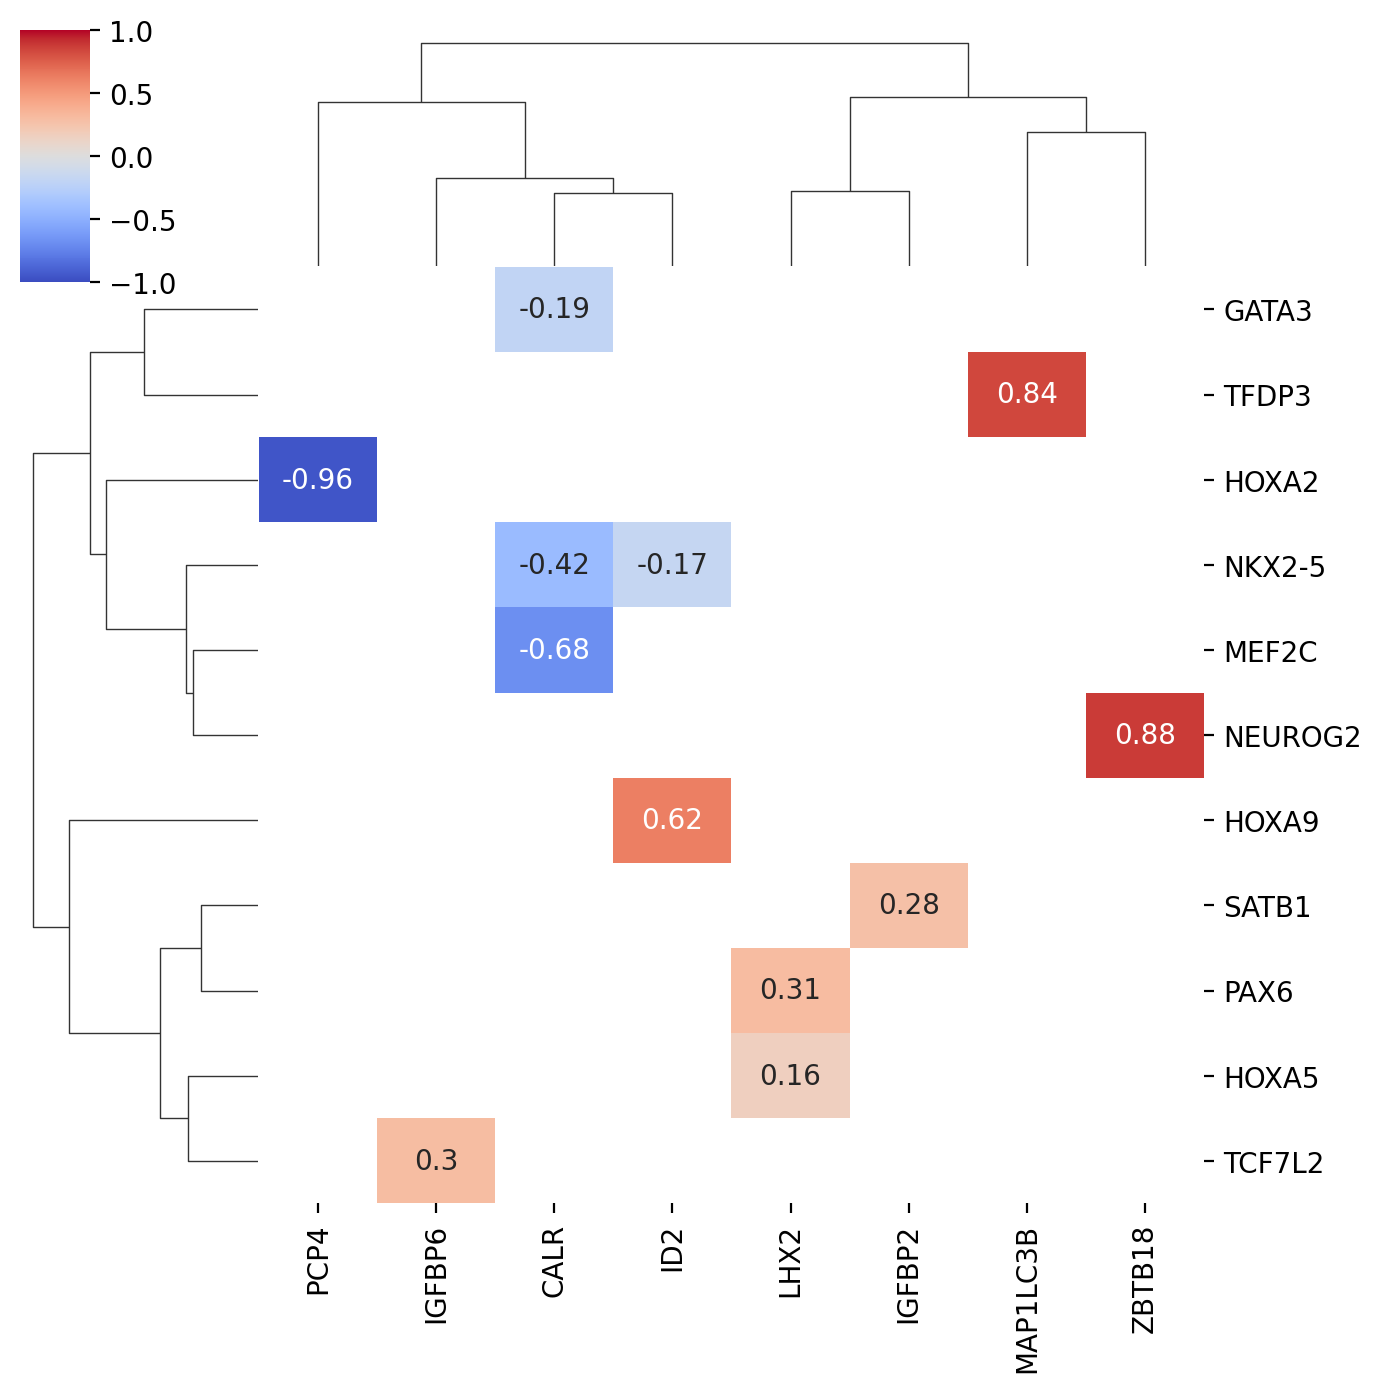

In [120]:
sns.clustermap(corr_df, cmap='coolwarm', center=0, vmin=-1, vmax=1, figsize=(7, 7), annot=True, mask=corr_mask.values)

<Axes: >

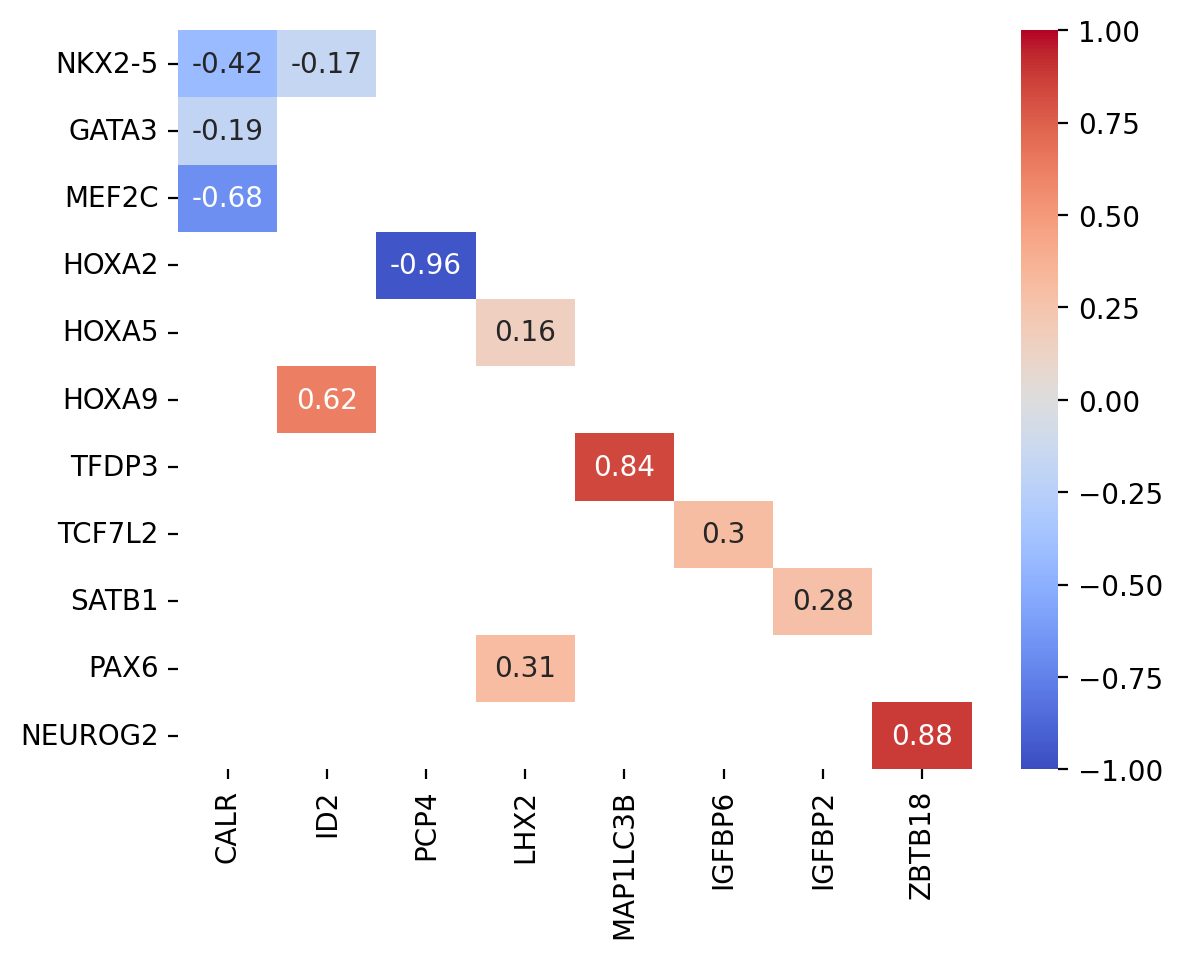

In [121]:
sns.heatmap(corr_df, cmap='coolwarm', center=0, vmin=-1, vmax=1, annot=True, mask=corr_mask.values)

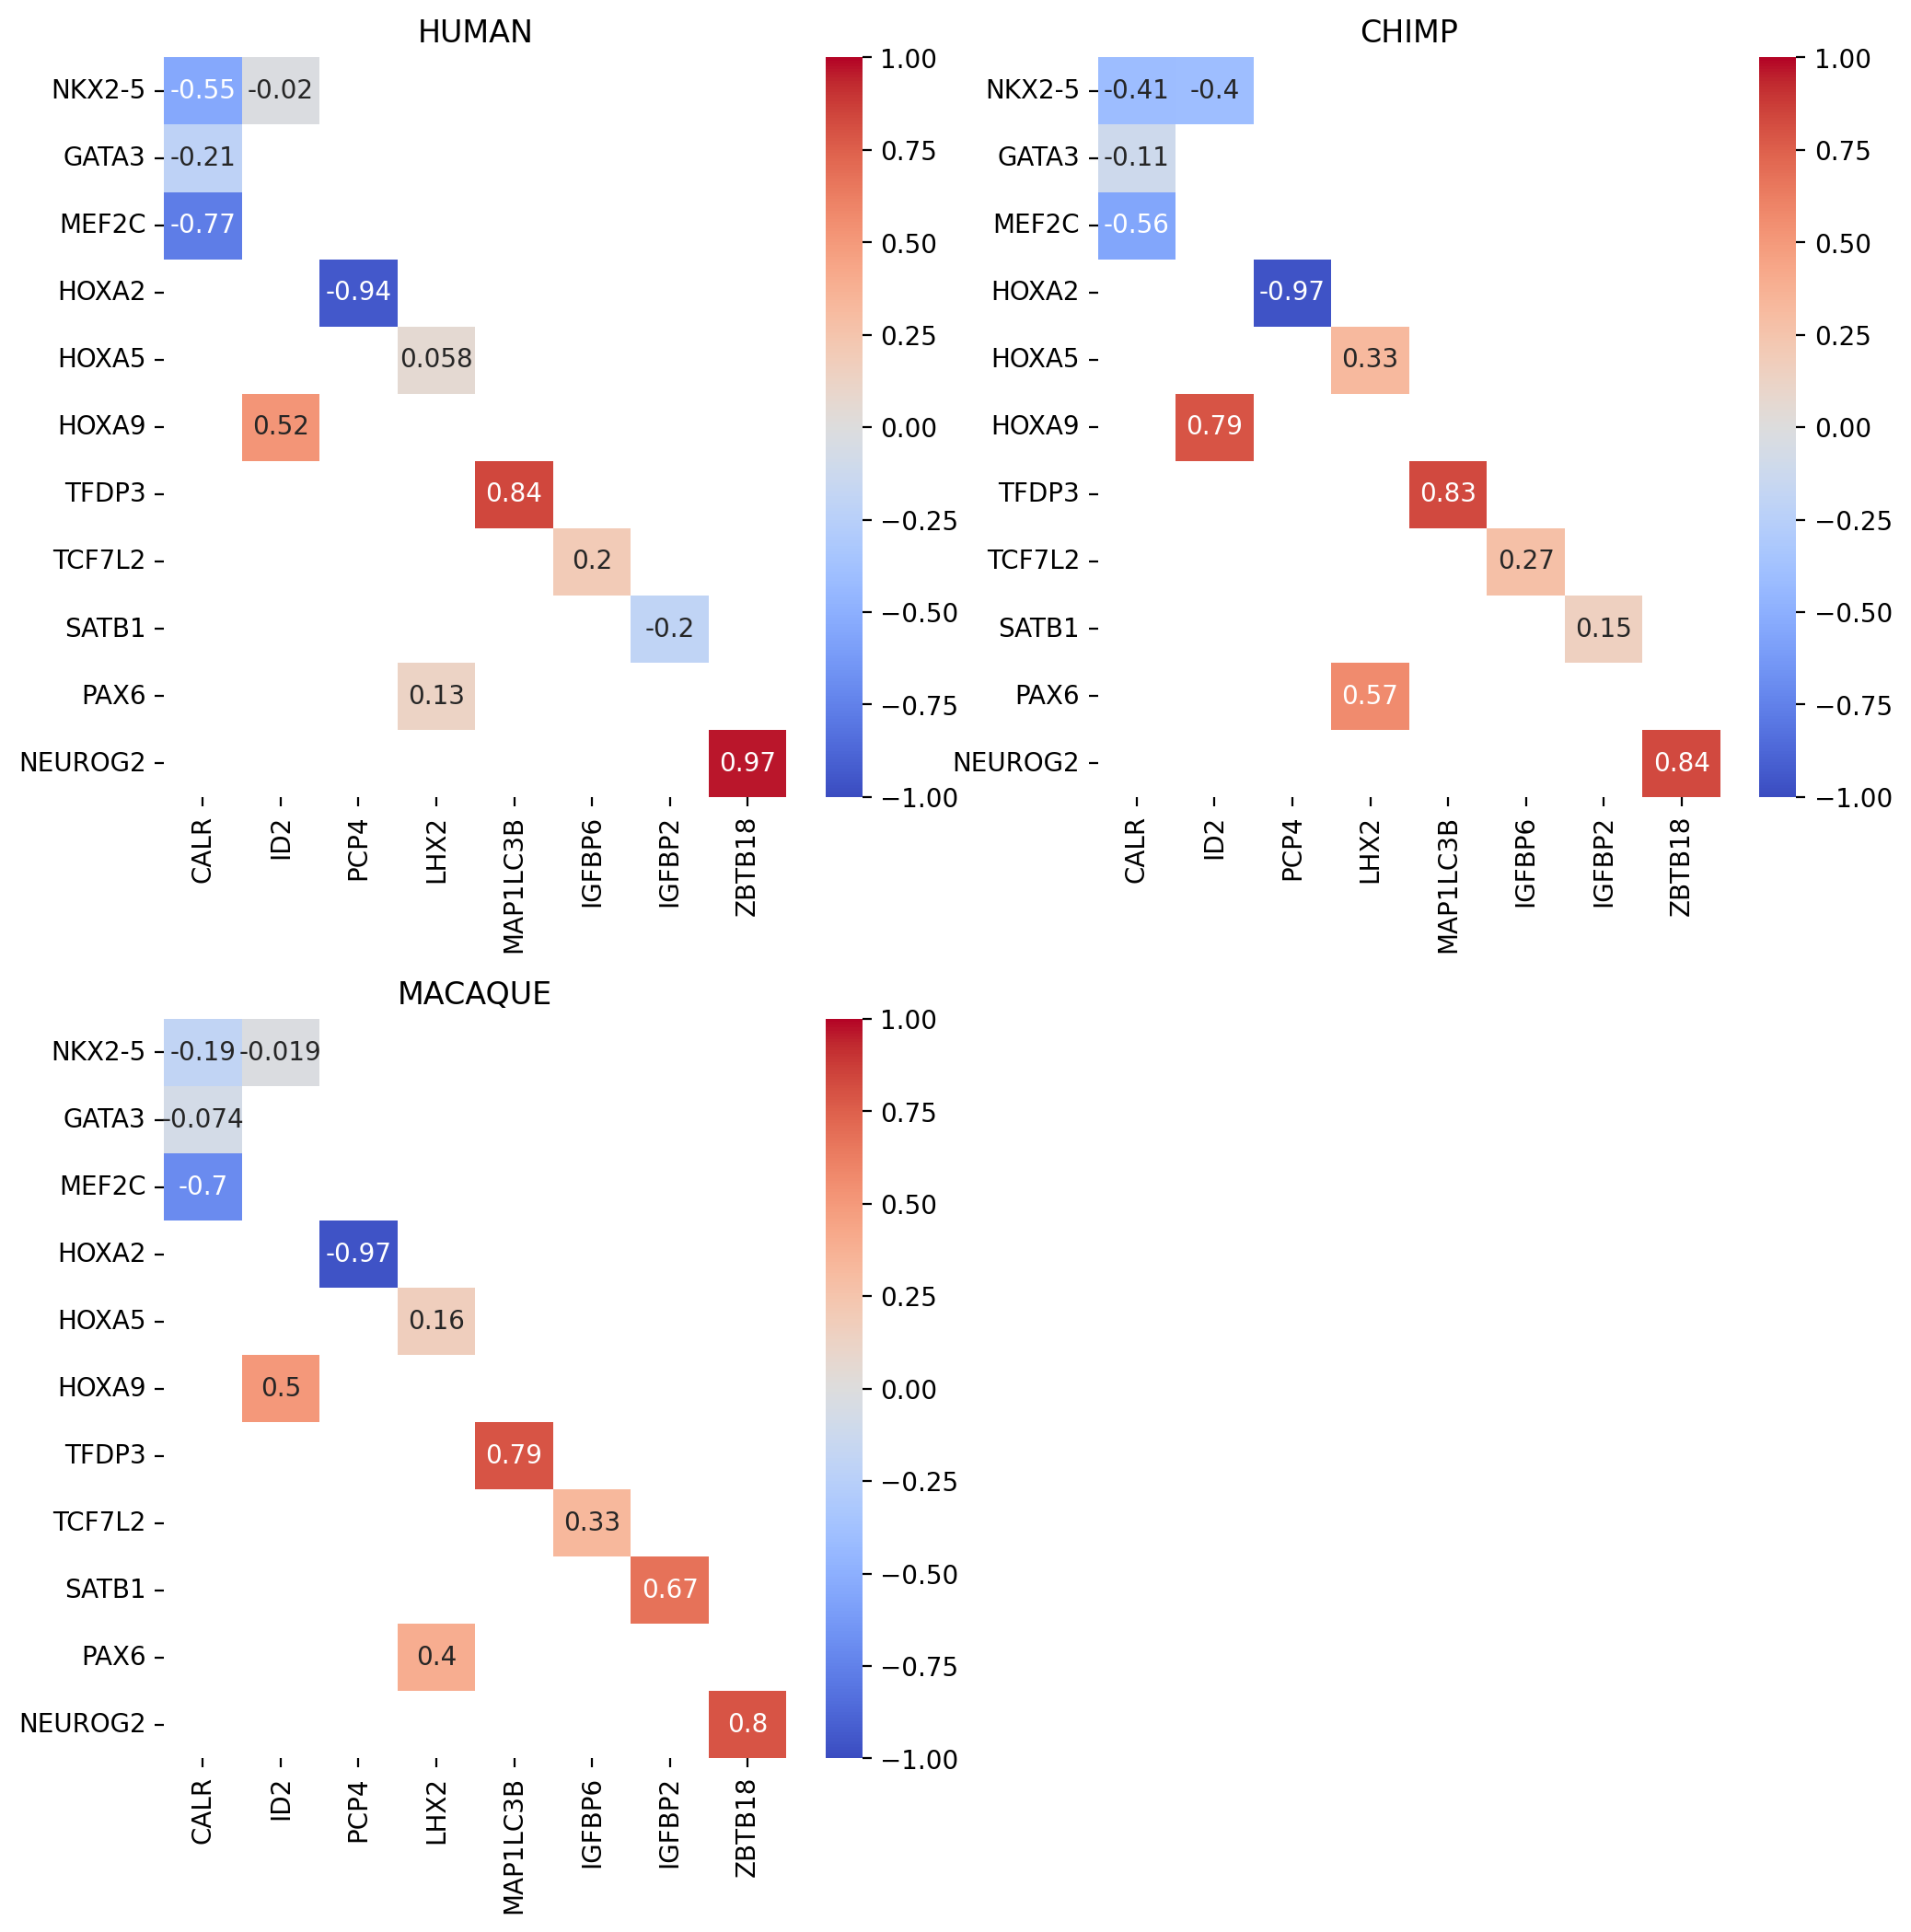

In [142]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), gridspec_kw={'hspace': 0.3})

for ax, sp in zip(axes.flatten(), ['human', 'chimp', 'macaque']):
    corr_df_sp = pd.concat([gene_df, act_df], axis=1)
    corr_df_sp = corr_df_sp.loc[corr_df_sp.index.str.contains(sp)].corr(method='spearman').loc[act_df.columns, gene_df.columns]

    sns.heatmap(corr_df_sp, cmap='coolwarm', center=0, vmin=-1, vmax=1, annot=True, mask=corr_mask.values, ax=ax)
    ax.set_title(sp.upper())

axes[1, 1].remove()